### Jansen–Rit Neural Mass Model
Why Jansen–Rit?

EEG time series	Jansen–Rit generates EEG-like signals

group-level comparison	You can fit parameters per subject/group

interpretability	Parameters map to neural circuit functions (e.g., gain, time constants)

simulate dynamics	Simulates oscillations, ERPs, resting activity

explain results	"Group B has reduced excitatory gain" is clear

Can Model and Compare

Parameter in Jansen–Rit	Interpretation	Why it Might Differ Between Groups

A (Excitatory gain)	Strength of excitatory postsynaptic input	Bad counters may have reduced excitation

B (Inhibitory gain)	Strength of inhibitory feedback	May reflect overcontrol or dysregulation

C (Connectivity scaling)	Loop gain between layers	Reflects hyper/hypo-connectivity

Input mean/frequency	Task-related stimulation	Captures how brain responds to input

can fit these per subject, then run Bayesian group comparison like you did with energy features.
🔍 What You’ll Get

    Simulated EEG signals per subject

    Spectral features (e.g., alpha peak, amplitude)

    Dynamical features (e.g., oscillation stability, bifurcation regime)

    Group-level differences in fitted parameters

In [ ]:
import pickle
import numpy as np
from scipy.signal import hilbert
from pathlib import Path
import mne

# Channel renaming
channel_mapping = {
    "EEG Fp1": "Fp1", "EEG Fp2": "Fp2", "EEG F3": "F3", "EEG F4": "F4",
    "EEG F7": "F7", "EEG F8": "F8", "EEG T3": "T3", "EEG T4": "T4",
    "EEG C3": "C3", "EEG C4": "C4", "EEG T5": "T5", "EEG T6": "T6",
    "EEG P3": "P3", "EEG P4": "P4", "EEG O1": "O1", "EEG O2": "O2",
    "EEG Fz": "Fz", "EEG Cz": "Cz", "EEG Pz": "Pz"
}
channels = list(channel_mapping.values())

# Frequency bands
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 45),
    'broadband': (1, 45)
}

# Envelope extractor per subject
def extract_band_envelopes(raw, bands=bands, channels=channels):
    raw = raw.copy()

    # Clean and restrict to EEG channels
    raw.rename_channels(lambda ch: ch.replace("EEG ", "") if ch.startswith("EEG ") else ch)
    raw.pick_channels(channels)
    raw.set_eeg_reference('average', projection=False)

    band_envelopes = {}
    for band, (low, high) in bands.items():
        try:
            # Bandpass
            raw_band = raw.copy().filter(low, high, fir_design='firwin', verbose=False)
            data = raw_band.get_data()

            # Hilbert envelope
            analytic = hilbert(data, axis=1)
            envelope = np.abs(analytic)

            # Average over channels
            mean_envelope = np.mean(envelope, axis=0)
            band_envelopes[band] = mean_envelope
        except Exception as e:
            print(f"❌ Failed band {band}: {e}")
    return band_envelopes

# Batch processor
def process_all_subjects(eeg_dict, label="rest"):
    band_data = {}
    for subj_id, raw in eeg_dict.items():
        try:
            band_data[subj_id] = extract_band_envelopes(raw)
            print(f"✅ {label.upper()} subject {subj_id} processed.")
        except Exception as e:
            print(f"❌ {label.upper()} subject {subj_id} failed: {e}")
    return band_data

# === Load EEG dicts ===
with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_rest_eeg_by_participant.pkl", "rb") as f:
    rest_eeg_dict = pickle.load(f)

with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_task_eeg_by_participant.pkl", "rb") as f:
    task_eeg_dict = pickle.load(f)

# === Run ===
band_env_rest = process_all_subjects(rest_eeg_dict, label="rest")
band_env_task = process_all_subjects(task_eeg_dict, label="task")

# === Save ===
Path("band_envelopes").mkdir(exist_ok=True)

with open("band_envelopes/band_envelopes_rest.pkl", "wb") as f:
    pickle.dump(band_env_rest, f)

with open("band_envelopes/band_envelopes_task.pkl", "wb") as f:
    pickle.dump(band_env_task, f)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
✅ REST subject 0 processed.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
✅ REST subject 29 processed.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
✅ REST subject 14 processed.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
✅ REST subject 5 processed.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referenci

In [2]:
def jansen_rit_simulate(A=3.25, B=22, C=135, mu=120, dt=0.0001, duration=1.0):
    """Simulates Jansen-Rit model and returns output EEG signal"""
    t = np.arange(0, duration, dt)
    n = len(t)

    # State variables
    y0 = np.zeros(n)
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y3 = np.zeros(n)
    y4 = np.zeros(n)
    y5 = np.zeros(n)

    # Parameters
    a = 100.0  # excitatory time constant
    b = 50.0   # inhibitory time constant
    e0 = 2.5
    v0 = 6.0
    r = 0.56

    def sigmoid(v):
        return 2 * e0 / (1 + np.exp(r * (v0 - v)))

    for i in range(2, n):
        p = mu + np.random.randn() * 2.0  # white noise input

        y0[i] = y0[i-1] + dt * y3[i-1]
        y3[i] = y3[i-1] + dt * (A * a * sigmoid(y1[i-1] - y2[i-1]) - 2 * a * y3[i-1] - a**2 * y0[i-1])
        y1[i] = y1[i-1] + dt * y4[i-1]
        y4[i] = y4[i-1] + dt * (A * a * (p + C * sigmoid(C * y0[i-1])) - 2 * a * y4[i-1] - a**2 * y1[i-1])
        y2[i] = y2[i-1] + dt * y5[i-1]
        y5[i] = y5[i-1] + dt * (B * b * C * sigmoid(C * y0[i-1]) - 2 * b * y5[i-1] - b**2 * y2[i-1])

    return y1 - y2  # pyramidal output


In [7]:
import pickle

# Load the pickle file
with open("band_envelopes/band_envelopes_rest.pkl", "rb") as f:
    band_envelopes_rest = pickle.load(f)

# Print top-level keys (subject IDs)
print("Subject IDs:", list(band_envelopes_rest.keys())[:5])  # show a few subjects

# Pick one subject
example_subject = list(band_envelopes_rest.keys())[0]

# Print bands available for that subject
print(f"\nAvailable bands for subject {example_subject}:")
print(band_envelopes_rest[example_subject].keys())

# Print size of each band signal
for band, signal in band_envelopes_rest[example_subject].items():
    print(f"  {band}: shape = {len(signal)}")


Subject IDs: ['0', '29', '14', '5', '2']

Available bands for subject 0:
dict_keys(['delta', 'theta', 'alpha', 'beta', 'gamma', 'broadband'])
  delta: shape = 91000
  theta: shape = 91000
  alpha: shape = 91000
  beta: shape = 91000
  gamma: shape = 91000
  broadband: shape = 91000


In [ ]:
import numpy as np
import pickle
from scipy.optimize import differential_evolution
from pathlib import Path
import os

# === Jansen-Rit model ===
def jansen_rit_simulate(A=3.25, B=22, C=135, mu=120, dt=0.002, duration=1.0, noise_std=2.0):
    t = np.arange(0, duration, dt)
    n = len(t)

    y0, y1, y2 = np.zeros(n), np.zeros(n), np.zeros(n)
    y3, y4, y5 = np.zeros(n), np.zeros(n), np.zeros(n)

    a, b = 100.0, 50.0
    e0, v0, r = 2.5, 6.0, 0.56

    def sigmoid(v): return 2 * e0 / (1 + np.exp(r * (v0 - v)))

    for i in range(2, n):
        p = mu + np.random.normal(0, noise_std)

        y0[i] = y0[i-1] + dt * y3[i-1]
        y3[i] = y3[i-1] + dt * (A * a * sigmoid(y1[i-1] - y2[i-1]) - 2 * a * y3[i-1] - a**2 * y0[i-1])

        y1[i] = y1[i-1] + dt * y4[i-1]
        y4[i] = y4[i-1] + dt * (A * a * (p + C * sigmoid(C * y0[i-1])) - 2 * a * y4[i-1] - a**2 * y1[i-1])

        y2[i] = y2[i-1] + dt * y5[i-1]
        y5[i] = y5[i-1] + dt * (B * b * C * sigmoid(C * y0[i-1]) - 2 * b * y5[i-1] - b**2 * y2[i-1])

    return y1 - y2  # Output

# === Cost function ===
def cost_function(params, target_signal, dt, duration):
    A, B, C, mu = params
    sim = jansen_rit_simulate(A=A, B=B, C=C, mu=mu, dt=dt, duration=duration)

    sim_len = len(sim)
    target_resampled = np.interp(
        np.linspace(0, len(target_signal) - 1, sim_len),
        np.arange(len(target_signal)),
        target_signal
    )

    sim_z = (sim - np.mean(sim)) / np.std(sim)
    tgt_z = (target_resampled - np.mean(target_resampled)) / np.std(target_resampled)

    return np.mean((sim_z - tgt_z) ** 2)

# === Fitting loop for any dataset ===
def fit_all_subjects(band_envelopes_dict, label="rest"):
    dt = 0.002
    duration = 1.0
    bounds = [(2, 6), (10, 30), (100, 150), (80, 140)]  # A, B, C, mu

    fitted_params = {}
    print(f"\n🚀 Starting parameter fitting for {label.upper()} data...")

    for subj_id, bands in band_envelopes_dict.items():
        if "alpha" not in bands:
            print(f"⚠️ Skipping subject {subj_id} (no alpha band)")
            continue
        try:
            target_signal = bands["alpha"]
            print(f"🔍 Fitting subject {subj_id}...")

            result = differential_evolution(
                func=cost_function,
                bounds=bounds,
                args=(target_signal, dt, duration),
                strategy='best1bin',
                maxiter=50,
                popsize=10,
                tol=1e-5,
                polish=True,
                disp=False
            )

            fitted_params[subj_id] = {
                "A": result.x[0],
                "B": result.x[1],
                "C": result.x[2],
                "mu": result.x[3],
                "loss": result.fun
            }

            print(f"✅ {label.capitalize()} | Subject {subj_id} | Loss = {result.fun:.5f}")

        except Exception as e:
            print(f"❌ Failed for subject {subj_id}: {e}")

    # Save results
    Path("jansen_rit").mkdir(exist_ok=True)
    save_path = f"jansen_rit/fitted_params_{label}.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(fitted_params, f)

    print(f"💾 Saved fitted parameters to {save_path}")
    print(f"📊 Total successful fits: {len(fitted_params)} / {len(band_envelopes_dict)}\n")
    return fitted_params

# === Load both datasets ===
with open("band_envelopes/band_envelopes_rest.pkl", "rb") as f:
    band_env_rest = pickle.load(f)

with open("band_envelopes/band_envelopes_task.pkl", "rb") as f:
    band_env_task = pickle.load(f)

# === Run fitting
fitted_rest = fit_all_subjects(band_env_rest, label="rest")
fitted_task = fit_all_subjects(band_env_task, label="task")





🚀 Starting parameter fitting for REST data...
🔍 Fitting subject 0...
✅ Rest | Subject 0 | Loss = 2.02079
🔍 Fitting subject 29...
✅ Rest | Subject 29 | Loss = 1.89603
🔍 Fitting subject 14...
✅ Rest | Subject 14 | Loss = 1.83809
🔍 Fitting subject 5...
✅ Rest | Subject 5 | Loss = 1.98473
🔍 Fitting subject 2...
✅ Rest | Subject 2 | Loss = 1.81833
🔍 Fitting subject 12...
✅ Rest | Subject 12 | Loss = 1.77416
🔍 Fitting subject 17...
✅ Rest | Subject 17 | Loss = 2.02960
🔍 Fitting subject 25...
✅ Rest | Subject 25 | Loss = 1.64370
🔍 Fitting subject 10...
✅ Rest | Subject 10 | Loss = 1.90535
🔍 Fitting subject 3...
✅ Rest | Subject 3 | Loss = 1.72264
🔍 Fitting subject 19...
✅ Rest | Subject 19 | Loss = 1.97974
🔍 Fitting subject 4...
✅ Rest | Subject 4 | Loss = 1.62859
🔍 Fitting subject 8...
✅ Rest | Subject 8 | Loss = 1.81849
🔍 Fitting subject 18...
✅ Rest | Subject 18 | Loss = 2.16836
🔍 Fitting subject 7...
✅ Rest | Subject 7 | Loss = 1.59243
🔍 Fitting subject 21...
✅ Rest | Subject 21 | Loss =

In [2]:


# === Function to load and save RIT features ===
def save_rit_features_for_ml(condition_label):
    param_file = f"jansen_rit/fitted_params_{condition_label}.pkl"
    output_file = f"all_features/rit_features_{condition_label}.pkl"

    try:
        with open(param_file, "rb") as f:
            param_dict = pickle.load(f)

        # Just save the dict — it's already subject-wise and model parameter-wise
        with open(output_file, "wb") as f:
            pickle.dump(param_dict, f)

        print(f"✅ Saved RIT features to {output_file}")
    except Exception as e:
        print(f"❌ Failed to save features for {condition_label}: {e}")

# === Save both
save_rit_features_for_ml("rest")
save_rit_features_for_ml("task")


✅ Saved RIT features to all_features/rit_features_rest.pkl
✅ Saved RIT features to all_features/rit_features_task.pkl



=== 🔍 Analyzing REST parameters ===

📊 Comparing parameter 'A' in REST
  Good mean: 4.269, Bad mean: 4.239


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


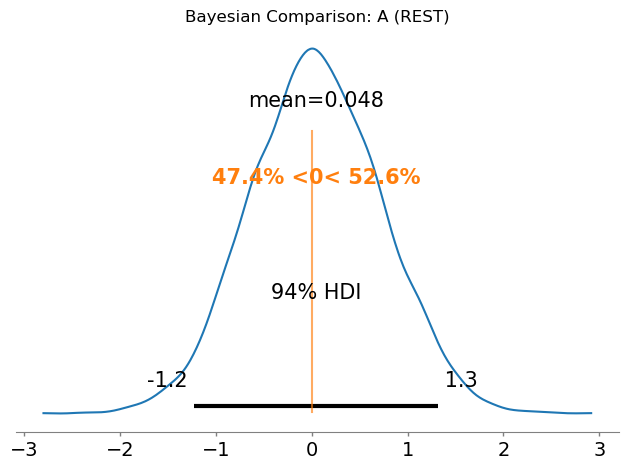

Initializing NUTS using jitter+adapt_diag...



📊 Comparing parameter 'B' in REST
  Good mean: 14.471, Bad mean: 16.718


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


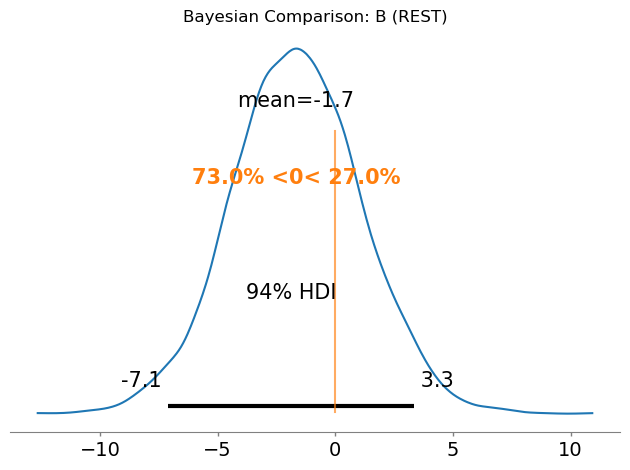

Initializing NUTS using jitter+adapt_diag...



📊 Comparing parameter 'C' in REST
  Good mean: 113.383, Bad mean: 115.140


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


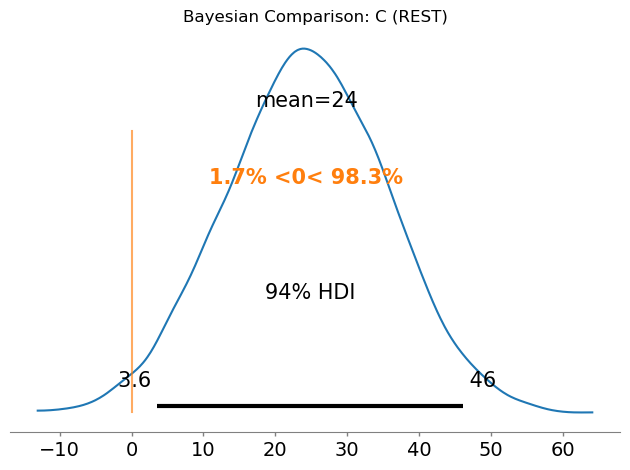

Initializing NUTS using jitter+adapt_diag...



📊 Comparing parameter 'mu' in REST
  Good mean: 125.044, Bad mean: 127.697


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


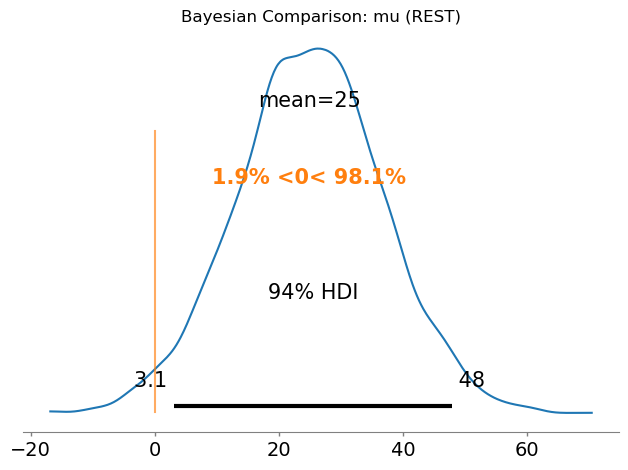

Initializing NUTS using jitter+adapt_diag...



📌 SUMMARY: REST

🔹 A:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff  0.048  0.686  -1.228    1.315      0.008    0.008    7033.0    5134.0   

      r_hat  
diff    1.0  


🔹 B:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff -1.668  2.755  -7.118    3.323      0.033    0.035    7070.0    4870.0   

      r_hat  
diff    1.0  


🔹 C:
        mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff  24.288  11.328   3.586   46.051      0.147    0.132    5906.0    5233.0   

      r_hat  
diff    1.0  


🔹 mu:
        mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff  24.924  11.824    3.14   47.962      0.155    0.145    5847.0    4732.0   

      r_hat  
diff    1.0  


=== 🔍 Analyzing TASK parameters ===

📊 Comparing parameter 'A' in TASK
  Good mean: 4.827, Bad mean: 4.146


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


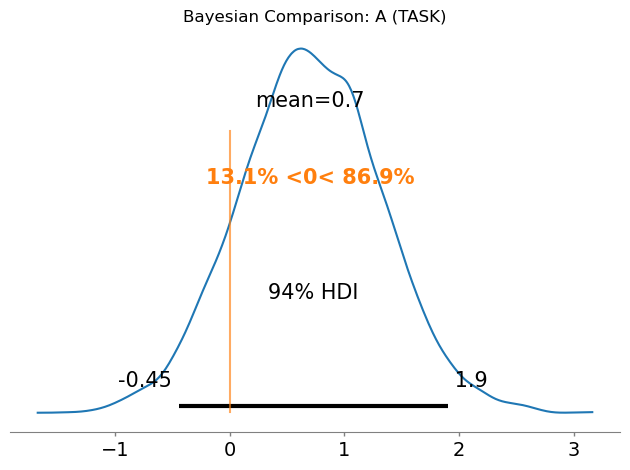

Initializing NUTS using jitter+adapt_diag...



📊 Comparing parameter 'B' in TASK
  Good mean: 14.529, Bad mean: 17.123


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


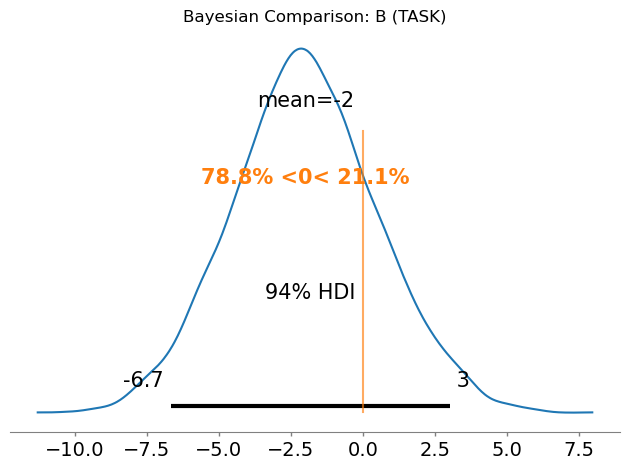

Initializing NUTS using jitter+adapt_diag...



📊 Comparing parameter 'C' in TASK
  Good mean: 112.917, Bad mean: 120.049


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


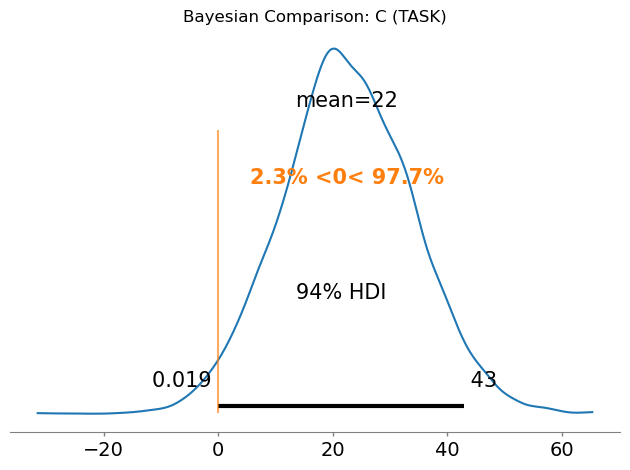


📊 Comparing parameter 'mu' in TASK
  Good mean: 127.781, Bad mean: 120.758


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


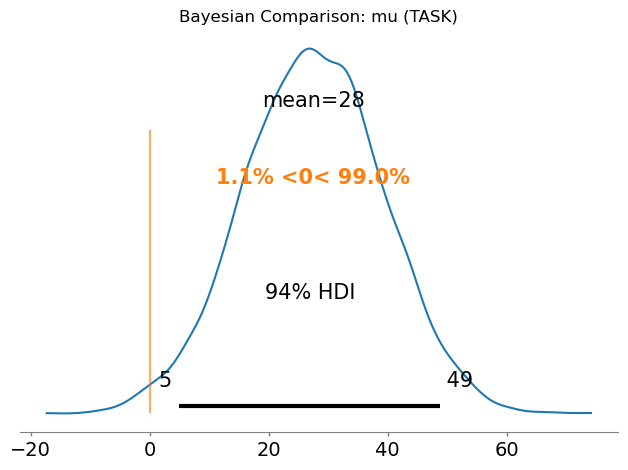


📌 SUMMARY: TASK

🔹 A:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff  0.699  0.627  -0.445    1.905      0.008    0.008    6662.0    4134.0   

      r_hat  
diff    1.0  


🔹 B:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff -2.002  2.555  -6.673    3.031      0.031    0.031    7071.0    4821.0   

      r_hat  
diff    1.0  


🔹 C:
       mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff  22.42  11.409   0.019   42.904      0.144    0.135    6357.0    5275.0   

      r_hat  
diff    1.0  


🔹 mu:
       mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff  27.53  11.677   4.986   48.851      0.146    0.132    6442.0    5313.0   

      r_hat  
diff    1.0  



In [10]:
import pickle
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import os

# === Group Labels ===
good_ids = ['1', '2', '3', '5', '7', '8', 
            '11', '12', '13', '15', '16', '17', 
            '18', '20', '23', '24', '25', '26', 
            '27', '28', '29', '31', '32', '33', 
            '34', '35']

bad_ids = ['0', '4', '6', '9', '10', 
           '14', '19', '21', '22', '30']

# === Bayesian comparison function ===
def run_bayesian_parameter_comparison(param_name, param_dict, good_ids, bad_ids, title_label="REST"):
    # Extract data
    good_vals = [param_dict[sid][param_name] for sid in good_ids if sid in param_dict and param_name in param_dict[sid]]
    bad_vals = [param_dict[sid][param_name] for sid in bad_ids if sid in param_dict and param_name in param_dict[sid]]

    if len(good_vals) < 3 or len(bad_vals) < 3:
        print(f"⚠️ Not enough data for parameter {param_name} in {title_label}. Skipping.")
        return None

    print(f"\n📊 Comparing parameter '{param_name}' in {title_label}")
    print(f"  Good mean: {np.mean(good_vals):.3f}, Bad mean: {np.mean(bad_vals):.3f}")

    with pm.Model():
        mu_good = pm.Normal("mu_good", mu=0, sigma=10)
        mu_bad = pm.Normal("mu_bad", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)

        obs_good = pm.Normal("obs_good", mu=mu_good, sigma=sigma, observed=good_vals)
        obs_bad = pm.Normal("obs_bad", mu=mu_bad, sigma=sigma, observed=bad_vals)

        diff = pm.Deterministic("diff", mu_good - mu_bad)

        trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, progressbar=True)

    # Plot
    az.plot_posterior(trace, var_names=["diff"], ref_val=0)
    plt.title(f"Bayesian Comparison: {param_name} ({title_label})")
    plt.tight_layout()
    plt.show()

    return az.summary(trace, var_names=["diff"])

# === Function to process a condition (rest/task)
def process_condition(condition_label):
    param_file = f"jansen_rit/fitted_params_{condition_label}.pkl"
    if not os.path.exists(param_file):
        print(f"❌ Missing file: {param_file}")
        return

    print(f"\n=== 🔍 Analyzing {condition_label.upper()} parameters ===")

    with open(param_file, "rb") as f:
        param_dict = pickle.load(f)

    summaries = {}
    for param in ["A", "B", "C", "mu"]:
        summary = run_bayesian_parameter_comparison(param, param_dict, good_ids, bad_ids, title_label=condition_label.upper())
        if summary is not None:
            summaries[param] = summary

    # Print all results
    print(f"\n📌 SUMMARY: {condition_label.upper()}")
    for param, table in summaries.items():
        print(f"\n🔹 {param}:\n{table}\n")

# === Run for both conditions ===
process_condition("rest")
process_condition("task")

| Parameter | Mean Difference (Good - Bad) | 94% HDI (approx)  | Interpretation                                                                    |
| --------- | ---------------------------- | ----------------- | --------------------------------------------------------------------------------- |
| **A**     | +0.70                        | \[−0.45, +1.91]   | Slight increase for good counters, but HDI includes 0 → **uncertain difference**  |
| **B**     | −2.00                        | \[−6.67, +3.03]   | Large uncertainty, HDI spans zero → **no clear difference**                       |
| **C**     | +22.42                       | \[\~0.02, +42.90] | Entire HDI > 0 → **likely higher in good counters** ✅                             |
| **mu**    | +27.53                       | \[+4.99, +48.85]  | Entire HDI > 0 → **strong evidence for higher external input in good counters** ✅ |


| Feature                     | Physiological Meaning              | Task Difference                                                               |
| --------------------------- | ---------------------------------- | ----------------------------------------------------------------------------- |
| **C** (intra-cortical gain) | Controls excitatory feedback       | Good counters show **stronger recurrent excitation** during task              |
| **mu** (external input)     | Background input or thalamic drive | Significantly **more external drive** in good counters during arithmetic task |


Great! You’ve successfully run Bayesian group comparisons for **TASK EEG**, and the results are quite insightful.

---

## 🔍 Summary of TASK EEG Bayesian Comparison

| Parameter | Mean Difference (Good - Bad) | 94% HDI (approx)  | Interpretation                                                                    |
| --------- | ---------------------------- | ----------------- | --------------------------------------------------------------------------------- |
| **A**     | +0.70                        | \[−0.45, +1.91]   | Slight increase for good counters, but HDI includes 0 → **uncertain difference**  |
| **B**     | −2.00                        | \[−6.67, +3.03]   | Large uncertainty, HDI spans zero → **no clear difference**                       |
| **C**     | +22.42                       | \[\~0.02, +42.90] | Entire HDI > 0 → **likely higher in good counters** ✅                             |
| **mu**    | +27.53                       | \[+4.99, +48.85]  | Entire HDI > 0 → **strong evidence for higher external input in good counters** ✅ |

---

## Interpretation

| Feature                     | Physiological Meaning              | Task Difference                                                               |
| --------------------------- | ---------------------------------- | ----------------------------------------------------------------------------- |
| **C** (intra-cortical gain) | Controls excitatory feedback       | Good counters show **stronger recurrent excitation** during task              |
| **mu** (external input)     | Background input or thalamic drive | Significantly **more external drive** in good counters during arithmetic task |

This is **consistent with cognitive engagement**:

* Good counters are **more driven** by external input (`mu`)
* Their cortical circuits exhibit **greater excitation gain** (`C`)

---

## What I Can Model Next:

### 1. **Rest vs Task Comparison** (within-subject)

Compare how parameters change **within each subject** from rest → task:

* `ΔC = C_task - C_rest`
* `Δmu = mu_task - mu_rest`
* Use **paired Bayesian t-test** to assess significance


---

### 2. **Multivariate Classification**

Train a logistic regression or Random Forest to predict **Good vs Bad** using:

* Jansen–Rit parameters (`A`, `B`, `C`, `mu`)
* Energy landscape features (you already computed)

---

### 3. **Model-Based Group Stratification**

Instead of raw labels:

* Cluster participants based on fitted parameters
* Check if new groupings align with behavior

---


In [13]:
import numpy as np
import pickle
from scipy.signal import welch
from scipy.stats import entropy
from pathlib import Path
import nolds
import os

# === Jansen–Rit Simulator with all parameters ===
def jansen_rit_simulate(A=3.25, B=22, C=135, mu=120, a=100.0, b=50.0, e0=2.5, v0=6.0, r=0.56,
                        dt=0.002, duration=1.0, noise_std=2.0, pulse=None):
    t = np.arange(0, duration, dt)
    n = len(t)

    y0, y1, y2 = np.zeros(n), np.zeros(n), np.zeros(n)
    y3, y4, y5 = np.zeros(n), np.zeros(n), np.zeros(n)

    def sigmoid(v):
        return 2 * e0 / (1 + np.exp(r * (v0 - v)))

    for i in range(2, n):
        input_mu = mu
        if pulse and pulse[0] < i * dt < pulse[1]:
            input_mu += pulse[2]
        p = input_mu + np.random.normal(0, noise_std)

        y0[i] = y0[i-1] + dt * y3[i-1]
        y3[i] = y3[i-1] + dt * (A * a * sigmoid(y1[i-1] - y2[i-1]) - 2 * a * y3[i-1] - a**2 * y0[i-1])

        y1[i] = y1[i-1] + dt * y4[i-1]
        y4[i] = y4[i-1] + dt * (A * a * (p + C * sigmoid(C * y0[i-1])) - 2 * a * y4[i-1] - a**2 * y1[i-1])

        y2[i] = y2[i-1] + dt * y5[i-1]
        y5[i] = y5[i-1] + dt * (B * b * C * sigmoid(C * y0[i-1]) - 2 * b * y5[i-1] - b**2 * y2[i-1])

    return y1 - y2  # Output from pyramidal neurons

# === Feature extractors ===
def dominant_frequency(signal, sfreq=500):
    freqs, psd = welch(signal, fs=sfreq)
    return freqs[np.argmax(psd)]

def signal_entropy(signal, bins=50):
    hist, _ = np.histogram(signal, bins=bins, density=True)
    return entropy(hist + 1e-8)

def lyapunov_exponent(signal):
    return nolds.lyap_r(signal)

def erp_features(signal, dt=0.002):
    peak_amp = np.max(signal)
    latency = np.argmax(signal) * dt
    width = np.sum(signal > (0.5 * peak_amp)) * dt
    return {
        "erp_amp": peak_amp,
        "erp_latency": latency,
        "erp_width": width
    }

# === Combine all features per subject ===
def extract_extended_features(params, duration=1.0):
    sim_params = {k: params[k] for k in ['A', 'B', 'C', 'mu']}
    a, b = 100.0, 50.0
    e0, v0, r = 2.5, 6.0, 0.56

    sim = jansen_rit_simulate(**sim_params, a=a, b=b, e0=e0, v0=v0, r=r, duration=duration)

    return {
        **sim_params,
        "a": a, "b": b,
        "e0": e0, "v0": v0, "r": r,
        "dominant_freq": dominant_frequency(sim),
        "entropy": signal_entropy(sim),
        "lyapunov": lyapunov_exponent(sim),
        **erp_features(sim)
    }

# === Process a .pkl file and save extended features ===
def extend_param_file(in_path, out_path, duration=1.0):
    with open(in_path, "rb") as f:
        fitted_params = pickle.load(f)

    extended = {}
    for subj_id, params in fitted_params.items():
        try:
            feats = extract_extended_features(params, duration=duration)
            extended[subj_id] = feats
            print(f"✅ Extended subject {subj_id}")
        except Exception as e:
            print(f"❌ Failed subject {subj_id}: {e}")

    Path(os.path.dirname(out_path)).mkdir(exist_ok=True)
    with open(out_path, "wb") as f:
        pickle.dump(extended, f)
    print(f"\n💾 Saved extended features to: {out_path}")

# === Run for both REST and TASK ===
extend_param_file("jansen_rit/fitted_params_rest.pkl", "jansen_rit/fitted_params_rest_extended.pkl")
extend_param_file("jansen_rit/fitted_params_task.pkl", "jansen_rit/fitted_params_task_extended.pkl")


✅ Extended subject 0
✅ Extended subject 29
✅ Extended subject 14
✅ Extended subject 5
✅ Extended subject 2
✅ Extended subject 12
✅ Extended subject 17
✅ Extended subject 25
✅ Extended subject 10
✅ Extended subject 3
✅ Extended subject 19


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/me

✅ Extended subject 4
✅ Extended subject 8
✅ Extended subject 18
✅ Extended subject 7
✅ Extended subject 21
✅ Extended subject 23
✅ Extended subject 34
✅ Extended subject 32
✅ Extended subject 13
✅ Extended subject 24
✅ Extended subject 33
✅ Extended subject 9


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/me

✅ Extended subject 20
✅ Extended subject 22
✅ Extended subject 15
✅ Extended subject 16
✅ Extended subject 6
✅ Extended subject 28
✅ Extended subject 30
✅ Extended subject 31
✅ Extended subject 35
✅ Extended subject 11
✅ Extended subject 26
✅ Extended subject 1
✅ Extended subject 27

💾 Saved extended features to: jansen_rit/fitted_params_rest_extended.pkl


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)


✅ Extended subject 2
✅ Extended subject 26
✅ Extended subject 20
✅ Extended subject 12
✅ Extended subject 21
✅ Extended subject 7
✅ Extended subject 35
✅ Extended subject 31
✅ Extended subject 18
✅ Extended subject 34
✅ Extended subject 29
✅ Extended subject 1
✅ Extended subject 13
✅ Extended subject 6
✅ Extended subject 14
✅ Extended subject 3
✅ Extended subject 19
✅ Extended subject 17
✅ Extended subject 10
✅ Extended subject 24
✅ Extended subject 16
✅ Extended subject 30
✅ Extended subject 11
✅ Extended subject 22
✅ Extended subject 8
✅ Extended subject 25


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/me

✅ Extended subject 9
✅ Extended subject 15
✅ Extended subject 0
✅ Extended subject 27
✅ Extended subject 4
✅ Extended subject 33
✅ Extended subject 23
✅ Extended subject 28
✅ Extended subject 5
✅ Extended subject 32

💾 Saved extended features to: jansen_rit/fitted_params_task_extended.pkl


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 24
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 125
  warnings.warn(msg.format(min_tsep), RuntimeWarning)



=== 🔍 Running Bayesian comparisons for REST ===

📊 REST: Comparing 'A'
  Good mean: 4.269, Bad mean: 4.239


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


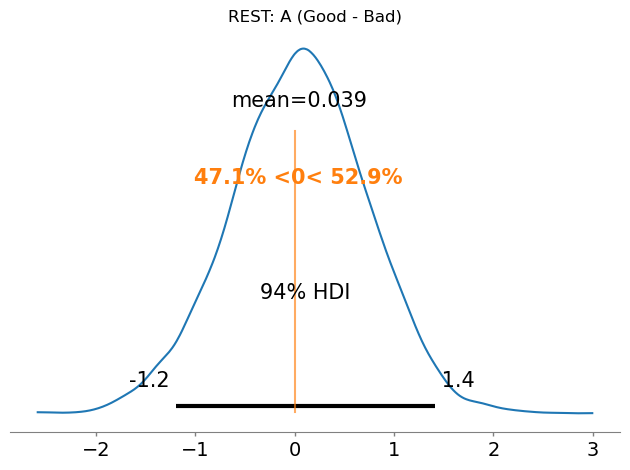

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'B'
  Good mean: 14.471, Bad mean: 16.718


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


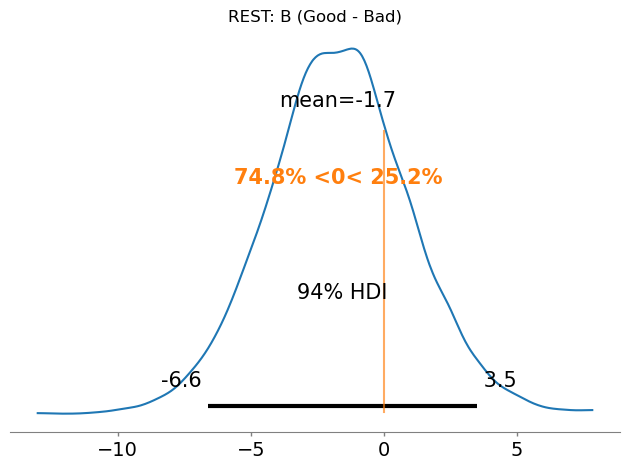

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'C'
  Good mean: 113.383, Bad mean: 115.140


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


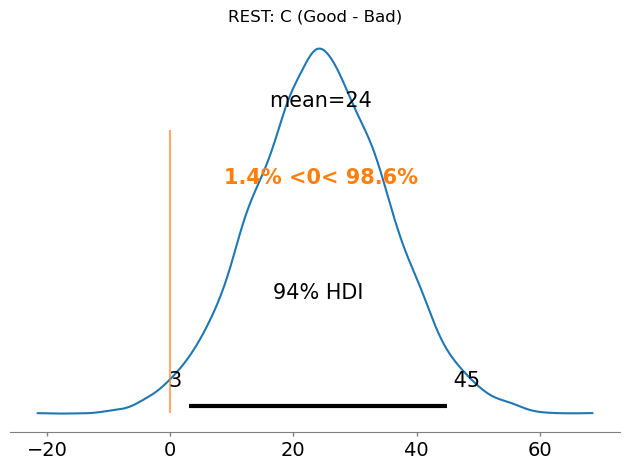

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'mu'
  Good mean: 125.044, Bad mean: 127.697


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


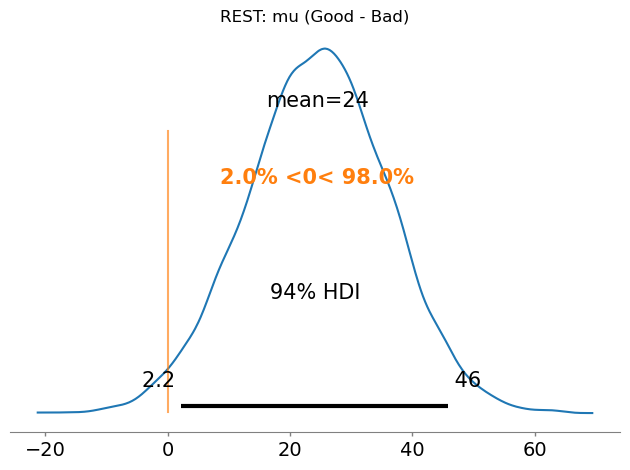

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'a'
  Good mean: 100.000, Bad mean: 100.000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


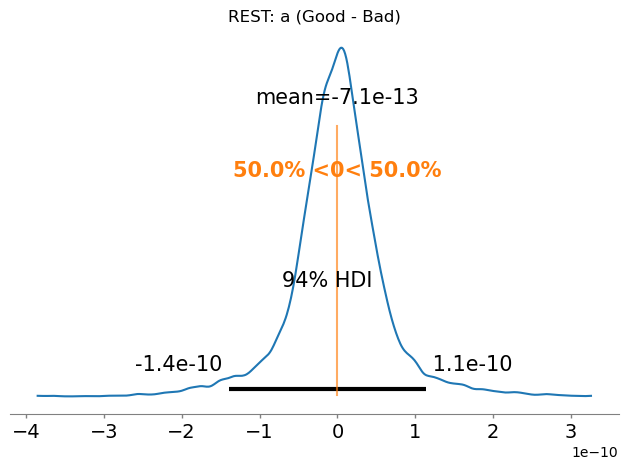

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'b'
  Good mean: 50.000, Bad mean: 50.000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


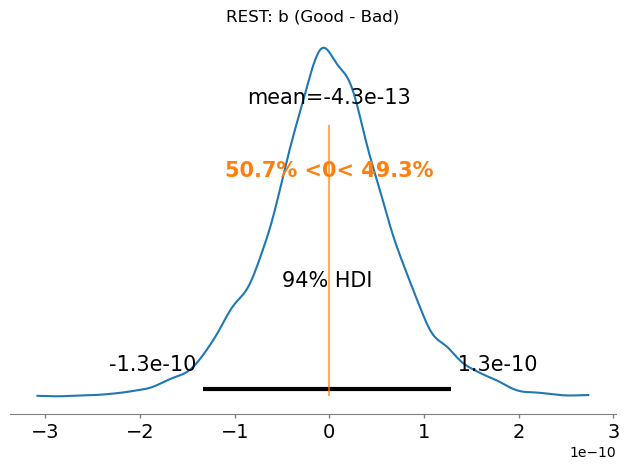

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'e0'
  Good mean: 2.500, Bad mean: 2.500


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 49 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


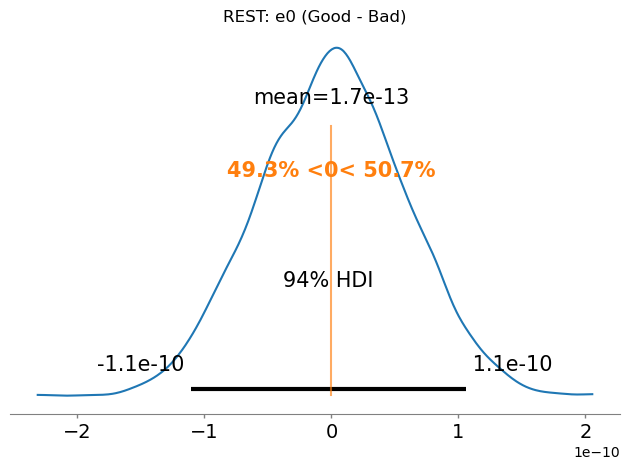

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'v0'
  Good mean: 6.000, Bad mean: 6.000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


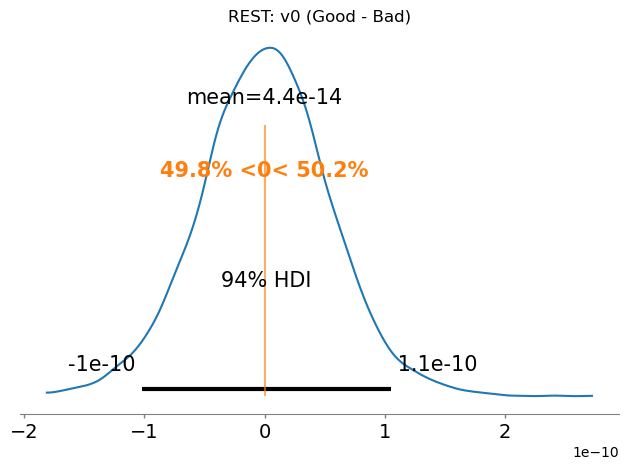


📊 REST: Comparing 'r'
  Good mean: 0.560, Bad mean: 0.560


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


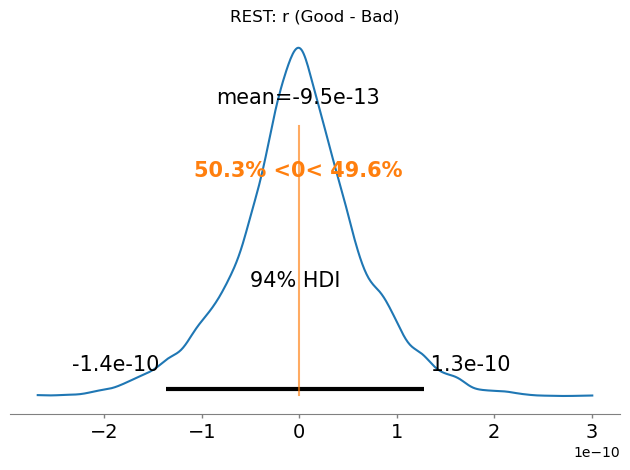

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'dominant_freq'
  Good mean: 3.531, Bad mean: 3.320


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


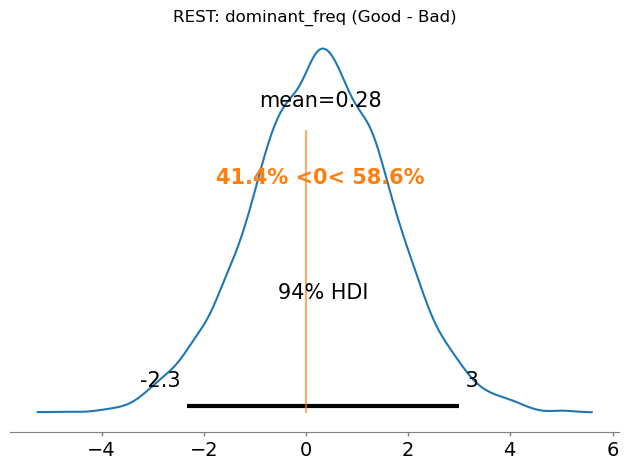

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'entropy'
  Good mean: 1.812, Bad mean: 1.725


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


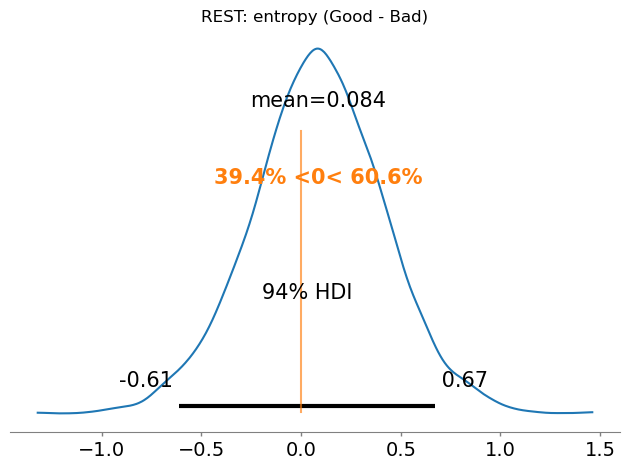

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'lyapunov'
  Good mean: -0.014, Bad mean: -0.016


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


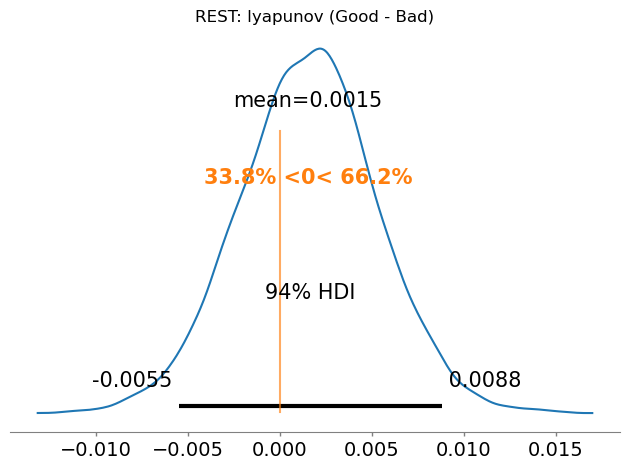

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'erp_amp'
  Good mean: 2.914, Bad mean: 2.893


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


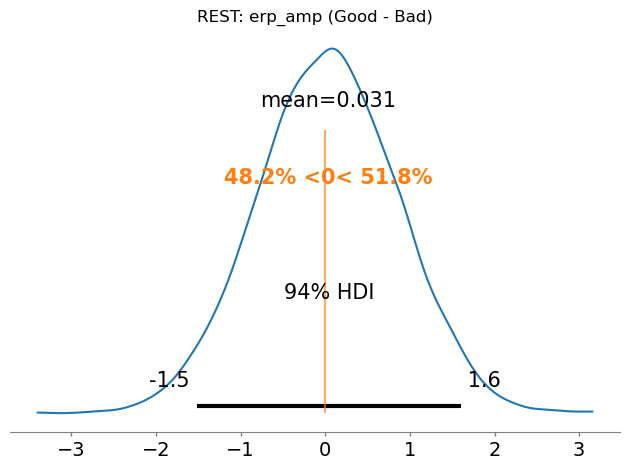

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'erp_latency'
  Good mean: 0.025, Bad mean: 0.023


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


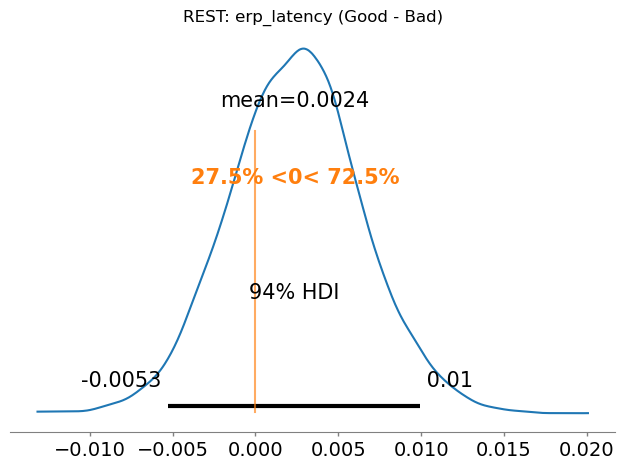

Initializing NUTS using jitter+adapt_diag...



📊 REST: Comparing 'erp_width'
  Good mean: 0.061, Bad mean: 0.066


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


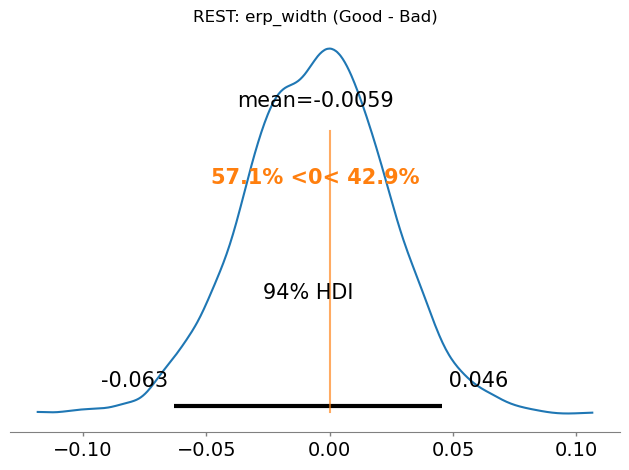

Initializing NUTS using jitter+adapt_diag...



📌 SUMMARY TABLE for REST:
Parameter             Diff Mean            HDI (low - high)
------------------------------------------------------------
A                         0.039   [-1.196, 1.407]
B                        -1.713   [-6.594, 3.504]
C                        24.419   [2.976, 44.950]
mu                       24.471   [2.242, 45.865]
a                        -0.000   [-0.000, 0.000]
b                        -0.000   [-0.000, 0.000]
e0                        0.000   [-0.000, 0.000]
v0                        0.000   [-0.000, 0.000]
r                        -0.000   [-0.000, 0.000]
dominant_freq             0.277   [-2.328, 2.998]
entropy                   0.084   [-0.611, 0.669]
lyapunov                  0.002   [-0.005, 0.009]
erp_amp                   0.031   [-1.519, 1.601]
erp_latency               0.002   [-0.005, 0.010]
erp_width                -0.006   [-0.063, 0.046]

=== 🔍 Running Bayesian comparisons for TASK ===

📊 TASK: Comparing 'A'
  Good mean: 4.827, Bad mean: 

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


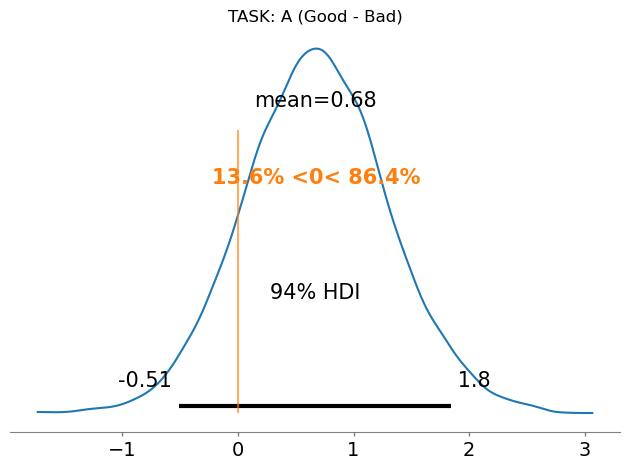

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'B'
  Good mean: 14.529, Bad mean: 17.123


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


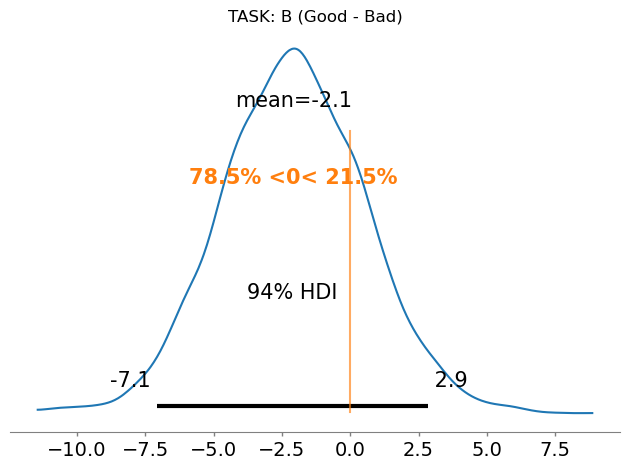

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'C'
  Good mean: 112.917, Bad mean: 120.049


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


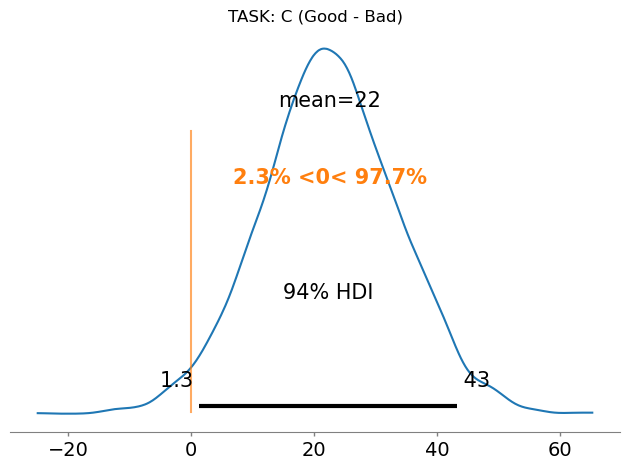

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'mu'
  Good mean: 127.781, Bad mean: 120.758


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


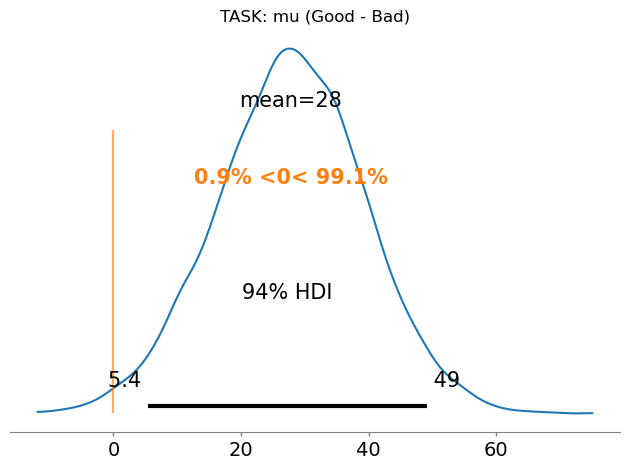

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'a'
  Good mean: 100.000, Bad mean: 100.000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


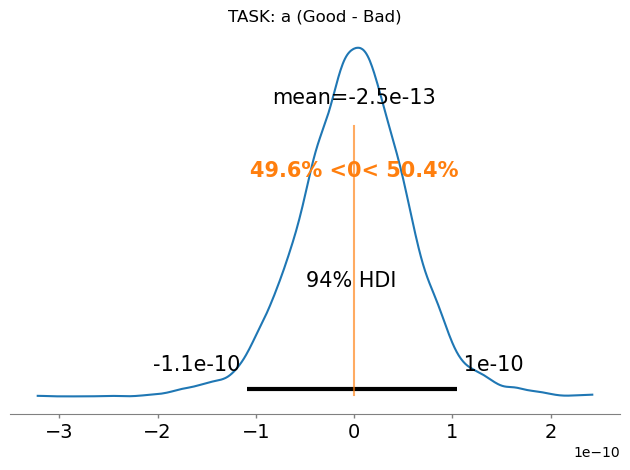

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'b'
  Good mean: 50.000, Bad mean: 50.000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


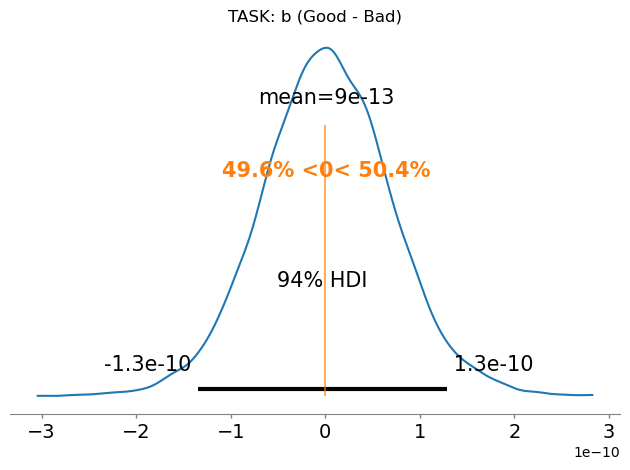

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'e0'
  Good mean: 2.500, Bad mean: 2.500


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


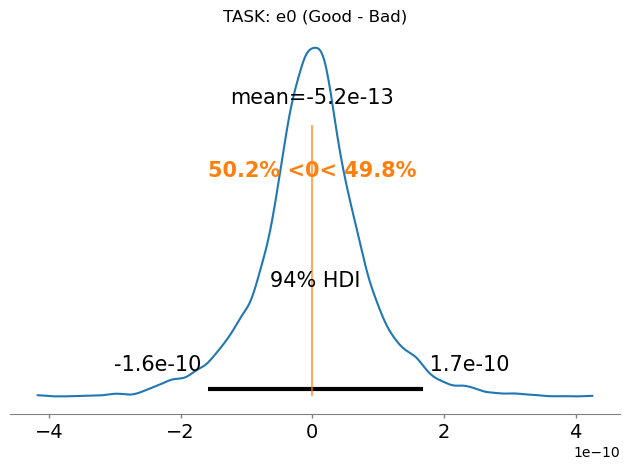

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'v0'
  Good mean: 6.000, Bad mean: 6.000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


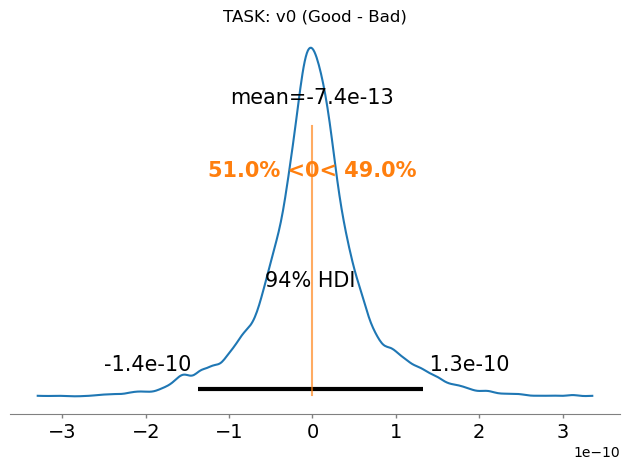

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'r'
  Good mean: 0.560, Bad mean: 0.560


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


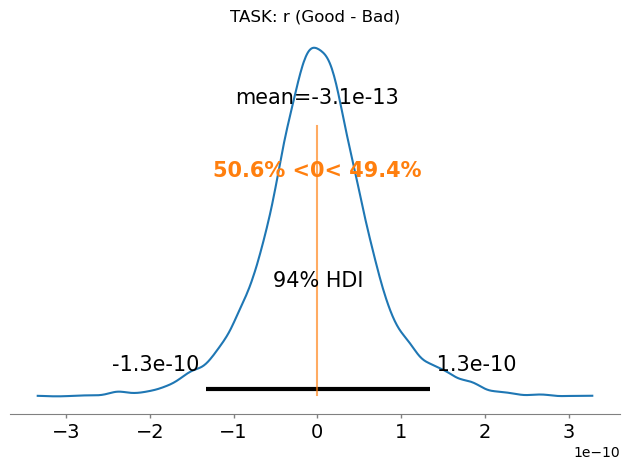

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'dominant_freq'
  Good mean: 4.582, Bad mean: 2.148


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


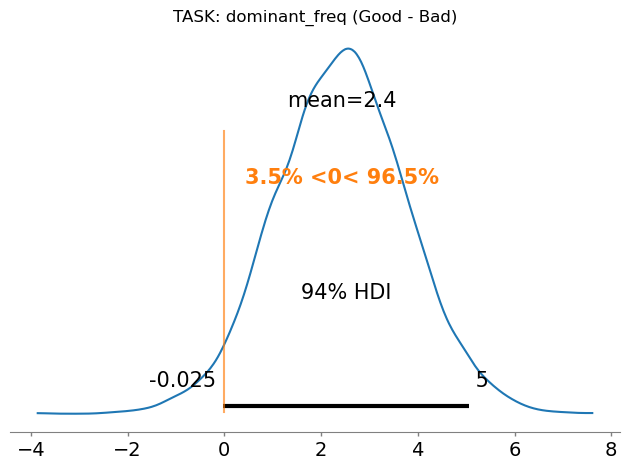

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'entropy'
  Good mean: 2.041, Bad mean: 1.619


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


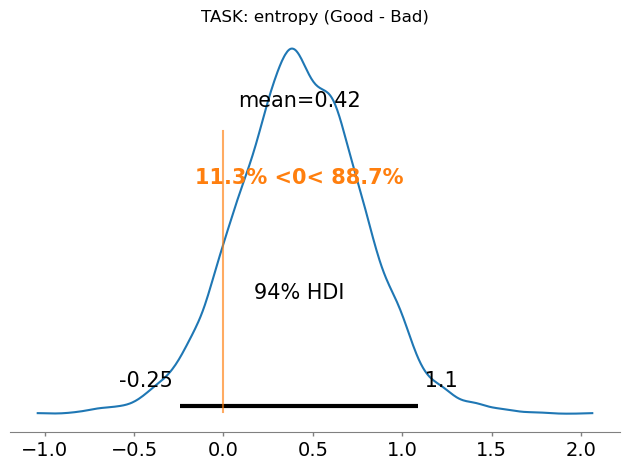

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'lyapunov'
  Good mean: -0.013, Bad mean: -0.017


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


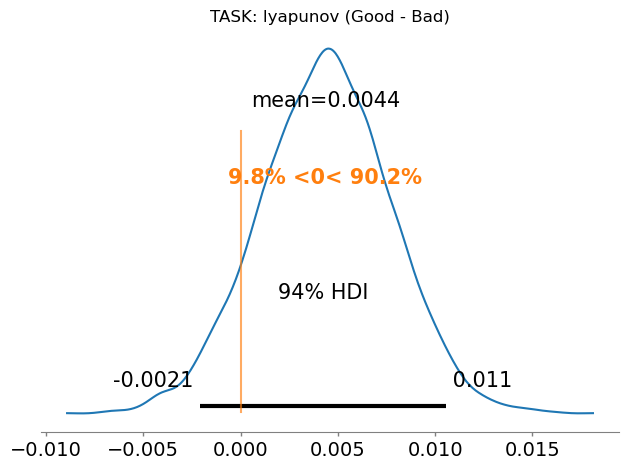

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'erp_amp'
  Good mean: 3.691, Bad mean: 2.632


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


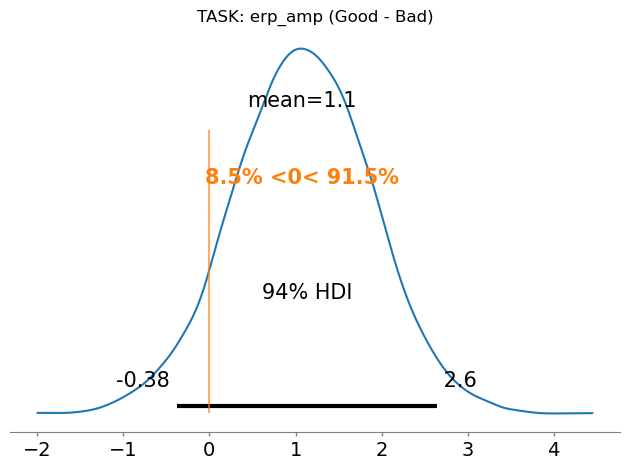

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'erp_latency'
  Good mean: 0.027, Bad mean: 0.021


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


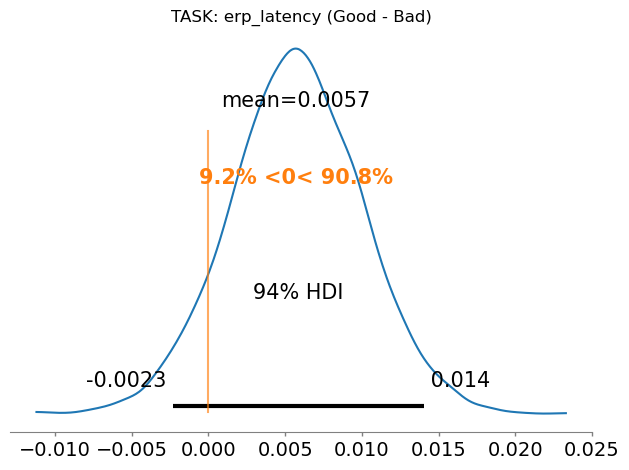

Initializing NUTS using jitter+adapt_diag...



📊 TASK: Comparing 'erp_width'
  Good mean: 0.082, Bad mean: 0.036


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]


/home/donaf-strange/anaconda3/envs/eeg_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


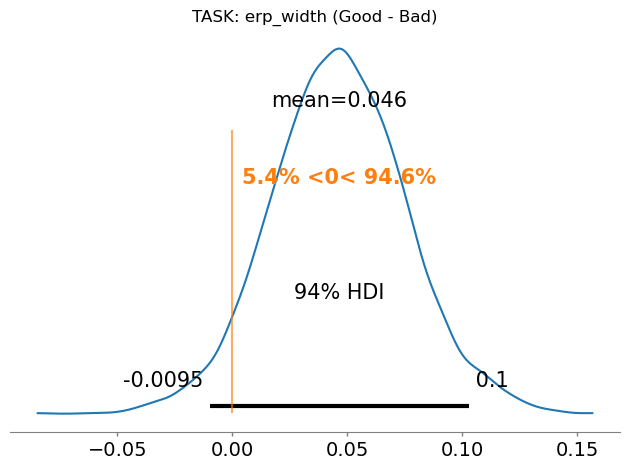


📌 SUMMARY TABLE for TASK:
Parameter             Diff Mean            HDI (low - high)
------------------------------------------------------------
A                         0.675   [-0.514, 1.846]
B                        -2.070   [-7.073, 2.857]
C                        22.466   [1.308, 43.117]
mu                       27.810   [5.437, 49.133]
a                        -0.000   [-0.000, 0.000]
b                         0.000   [-0.000, 0.000]
e0                       -0.000   [-0.000, 0.000]
v0                       -0.000   [-0.000, 0.000]
r                        -0.000   [-0.000, 0.000]
dominant_freq             2.422   [-0.025, 5.050]
entropy                   0.425   [-0.246, 1.088]
lyapunov                  0.004   [-0.002, 0.011]
erp_amp                   1.078   [-0.381, 2.642]
erp_latency               0.006   [-0.002, 0.014]
erp_width                 0.046   [-0.010, 0.103]


In [18]:
import pickle
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os

# === Define subject groups ===
good_ids = ['1', '2', '3', '5', '7', '8',
            '11', '12', '13', '15', '16', '17',
            '18', '20', '23', '24', '25', '26',
            '27', '28', '29', '31', '32', '33',
            '34', '35']

bad_ids = ['0', '4', '6', '9', '10',
           '14', '19', '21', '22', '30']

# === Bayesian group comparison ===
def bayesian_compare_feature(param_name, data_dict, good_ids, bad_ids, label="REST"):
    good_vals = [data_dict[sid][param_name] for sid in good_ids if sid in data_dict and param_name in data_dict[sid]]
    bad_vals = [data_dict[sid][param_name] for sid in bad_ids if sid in data_dict and param_name in data_dict[sid]]

    if len(good_vals) < 3 or len(bad_vals) < 3:
        print(f"⚠️ Not enough data for {param_name} in {label}")
        return None

    print(f"\n📊 {label}: Comparing '{param_name}'")
    print(f"  Good mean: {np.mean(good_vals):.3f}, Bad mean: {np.mean(bad_vals):.3f}")

    with pm.Model():
        mu_good = pm.Normal("mu_good", mu=0, sigma=10)
        mu_bad = pm.Normal("mu_bad", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)

        pm.Normal("obs_good", mu=mu_good, sigma=sigma, observed=good_vals)
        pm.Normal("obs_bad", mu=mu_bad, sigma=sigma, observed=bad_vals)

        diff = pm.Deterministic("diff", mu_good - mu_bad)

        trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, progressbar=True)

    az.plot_posterior(trace, var_names=["diff"], ref_val=0)
    plt.title(f"{label}: {param_name} (Good - Bad)")
    plt.tight_layout()
    plt.show()

    return az.summary(trace, var_names=["diff"])


# === Function to process all features ===
def process_extended_feature_file(pkl_path, label="REST"):
    if not os.path.exists(pkl_path):
        print(f"❌ Missing file: {pkl_path}")
        return

    with open(pkl_path, "rb") as f:
        feature_dict = pickle.load(f)

    feature_keys = list(next(iter(feature_dict.values())).keys())
    results = {}

    print(f"\n=== 🔍 Running Bayesian comparisons for {label.upper()} ===")
    for param in feature_keys:
        summary = bayesian_compare_feature(param, feature_dict, good_ids, bad_ids, label=label)
        if summary is not None:
            results[param] = summary

    # === Summary Table ===
    print(f"\n📌 SUMMARY TABLE for {label.upper()}:")
    print(f"{'Parameter':<20} {'Diff Mean':>10}   {'HDI (low - high)':>25}")
    print("-" * 60)
    for param, df in results.items():
        mean = df.loc['diff', 'mean']

        # Robust HDI extraction
        hdi_cols = [col for col in df.columns if 'hdi' in col]
        if len(hdi_cols) >= 2:
            hdi_low = df.loc['diff', hdi_cols[0]]
            hdi_high = df.loc['diff', hdi_cols[1]]
            print(f"{param:<20} {mean:>10.3f}   [{hdi_low:.3f}, {hdi_high:.3f}]")
        else:
            print(f"{param:<20} {mean:>10.3f}   [HDI N/A]")

    return results

# === Run for REST and TASK ===
results_rest = process_extended_feature_file("jansen_rit/fitted_params_rest_extended.pkl", label="REST")
results_task = process_extended_feature_file("jansen_rit/fitted_params_task_extended.pkl", label="TASK")




| Parameter  | REST             | TASK             | Interpretation                            |
| ---------- | ---------------- | ---------------- | ----------------------------------------- |
| **C**      | ✅ \[2.98, 44.95] | ✅ \[1.31, 43.12] | Larger coupling strength in Good counters |
| **μ (mu)** | ✅ \[2.24, 45.87] | ✅ \[5.44, 49.13] | Higher external input in Good counters    |

These two are **robust across both rest and task**, indicating Good counters might operate in a **stronger-driven and more interconnected regime**.

---

### 2. **Near-Significant (borderline or trend-level)**

| Parameter          | TASK HDI         | Notes                                            |
| ------------------ | ---------------- | ------------------------------------------------ |
| **dominant\_freq** | \[-0.025, 5.050] | Possibly higher frequency in task for Good group |
| **erp\_amp**       | \[-0.381, 2.642] | Increased ERP response amplitude in Good group   |
| **entropy**        | \[-0.246, 1.088] | Slight trend for higher complexity               |

These suggest Good counters may engage more oscillatory or information-rich dynamics under task demand.

---

### 3. **No Evidence for Group Differences**

All others like `A`, `B`, `a`, `b`, `e0`, `v0`, `r`, `lyapunov`, `erp_latency`, `erp_width` have HDIs that include zero with tight bounds.

---

## Interpretation: What This Suggests

* Good performers may operate under:

  * **higher excitatory drive (μ)**,
  * **stronger long-range connectivity (C)**,
  * possibly **faster oscillations (dominant\_freq)**,
  * and **more responsive ERPs**.

This aligns with theories of efficient cortical processing under cognitive load.

---


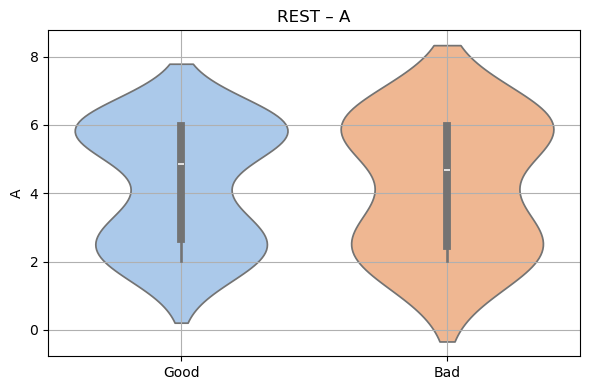

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


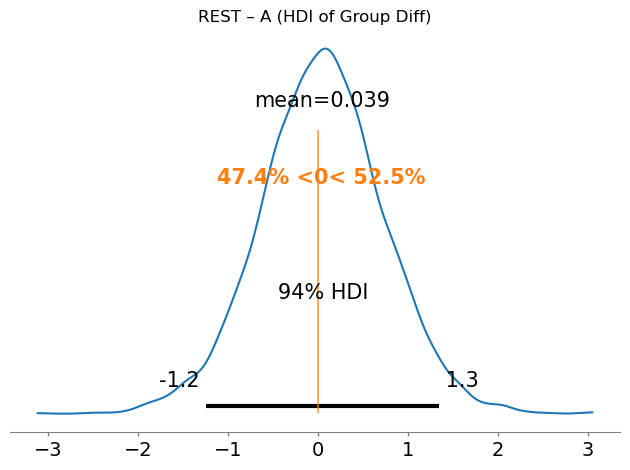

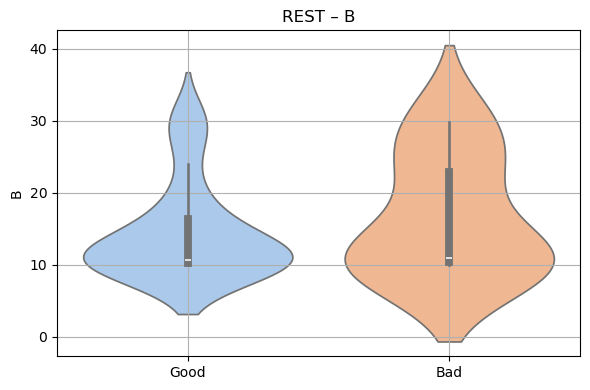

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


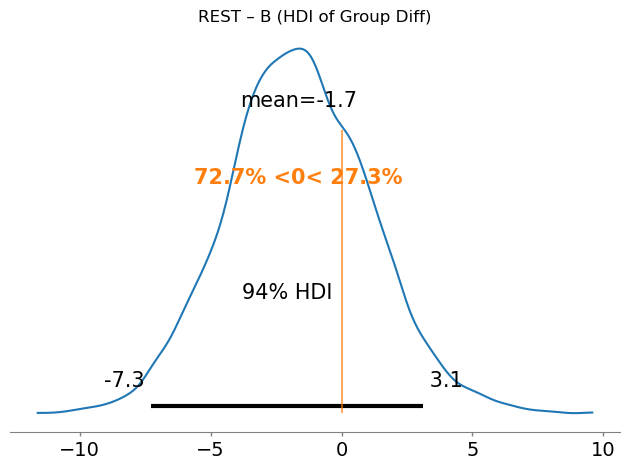

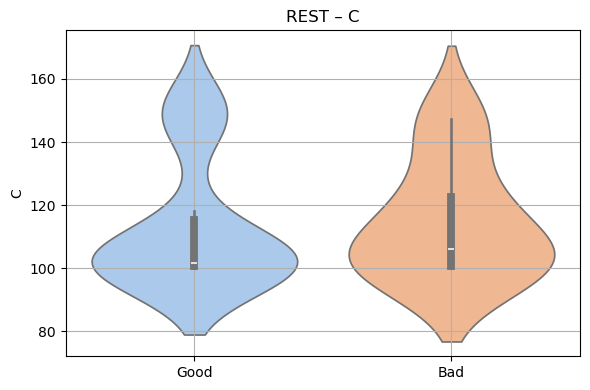

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


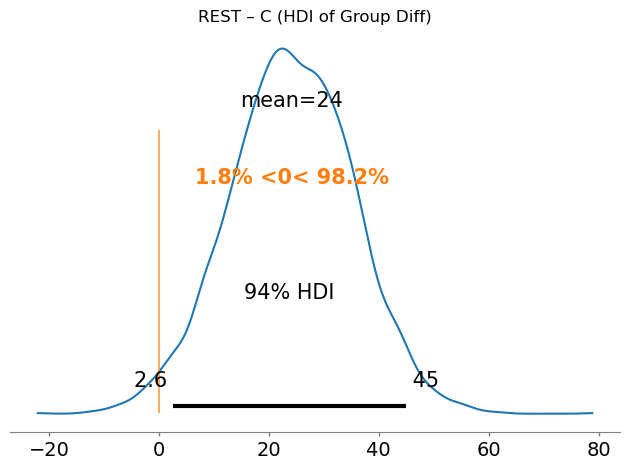

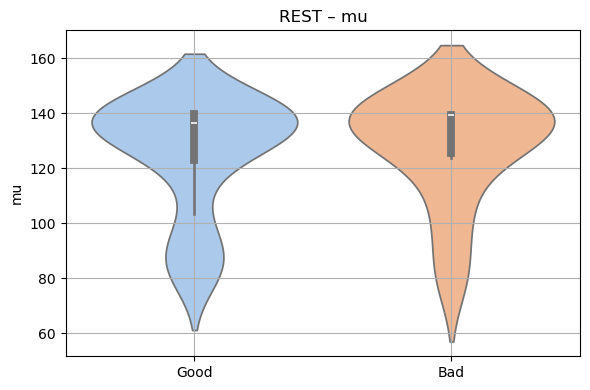

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


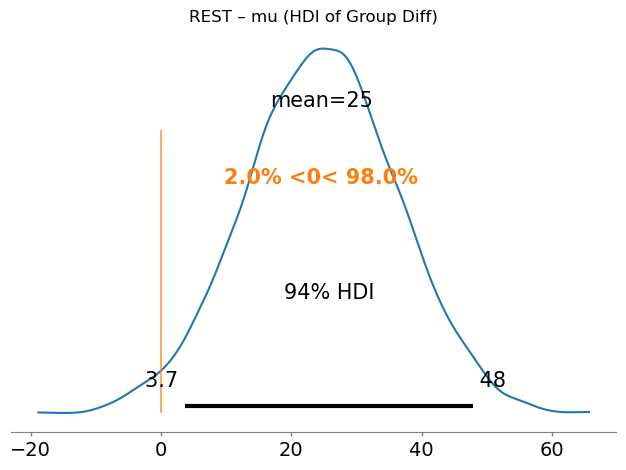

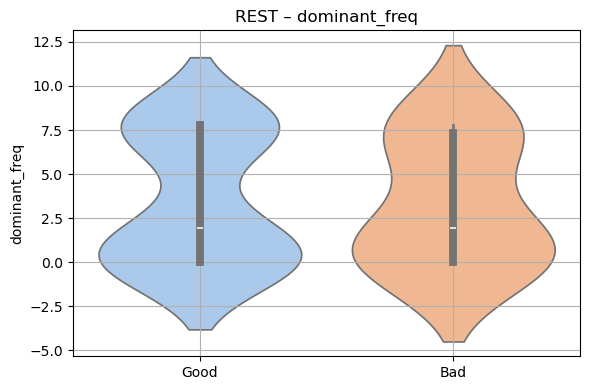

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


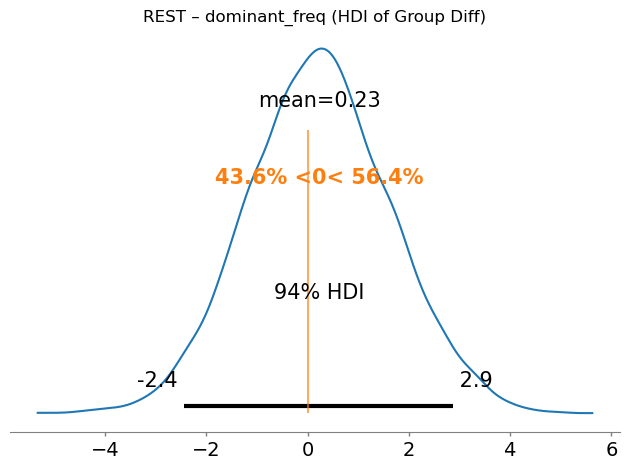

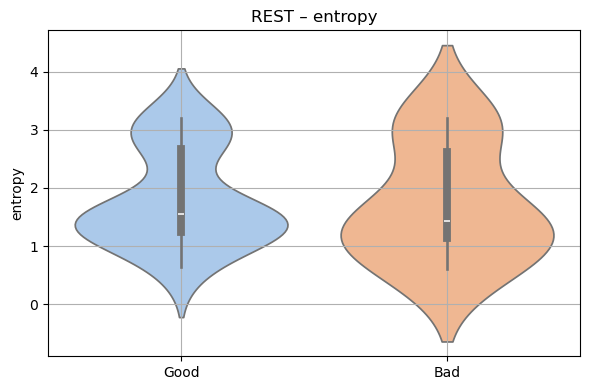

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


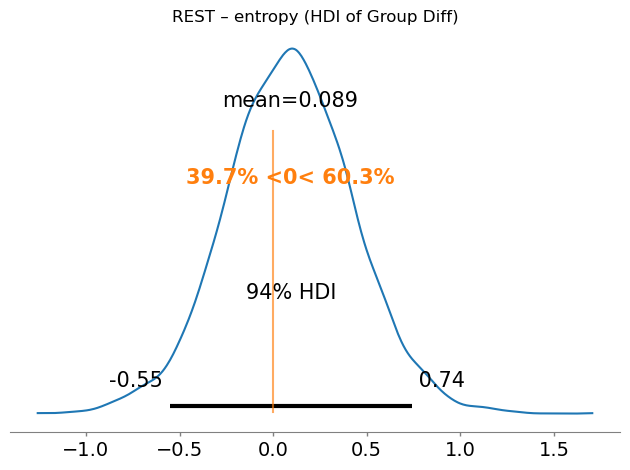

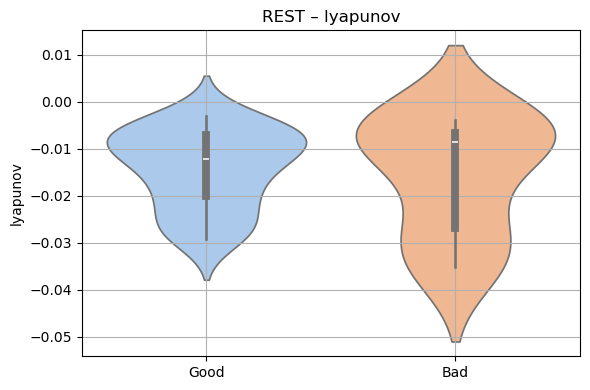

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


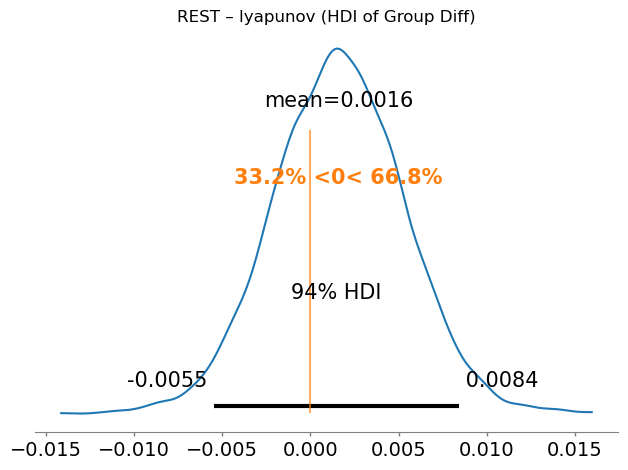

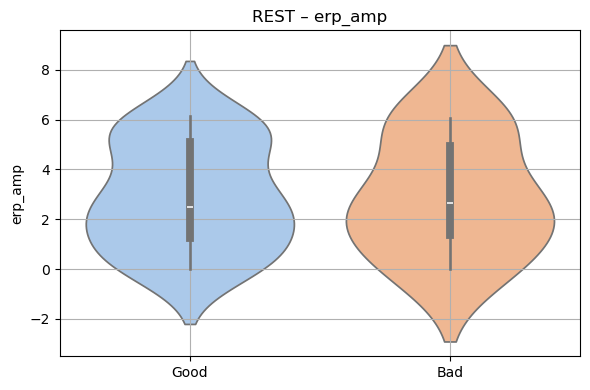

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


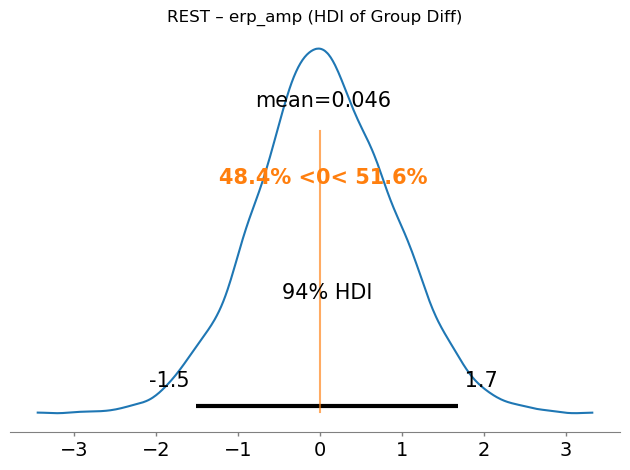

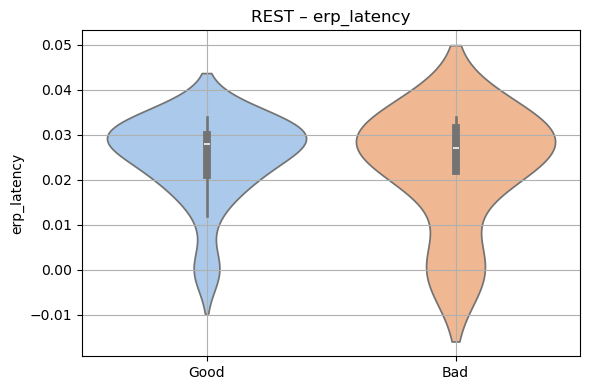

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


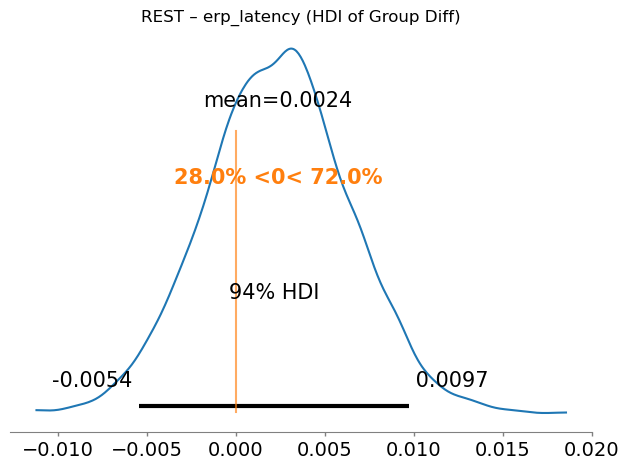

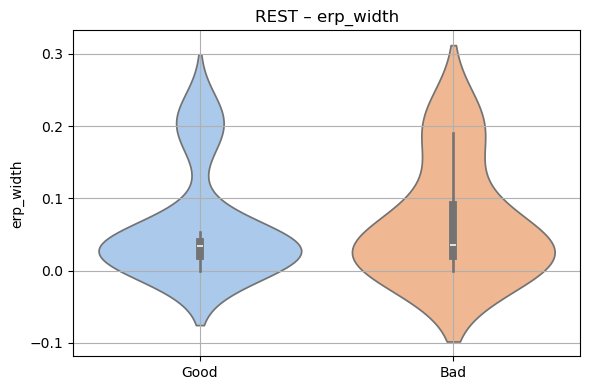

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


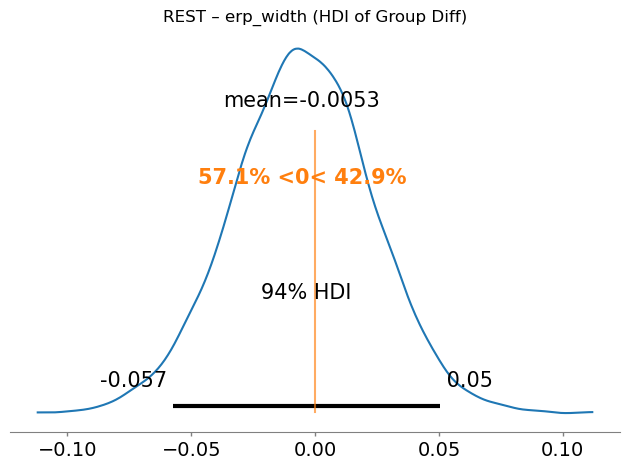

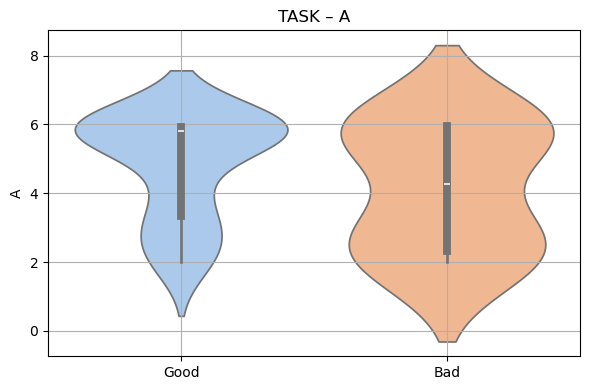

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


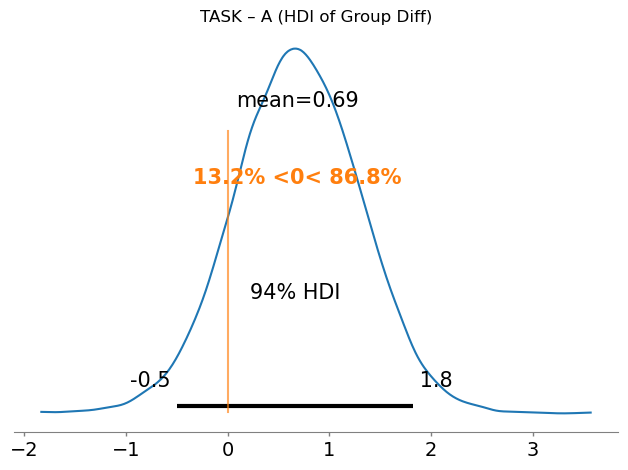

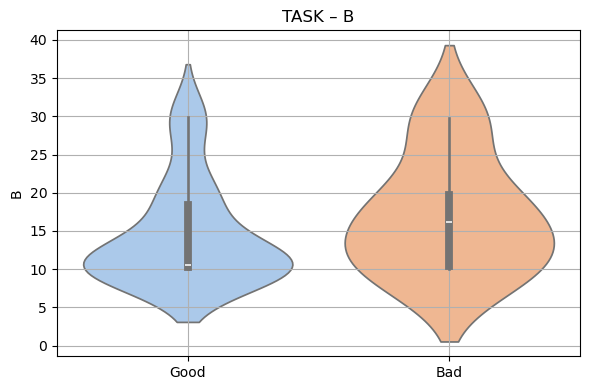

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


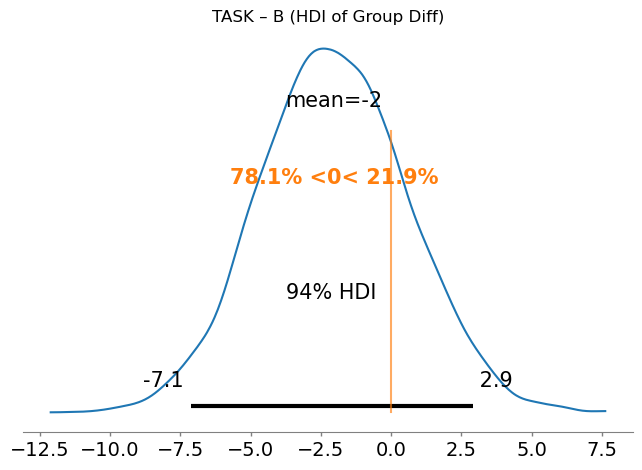

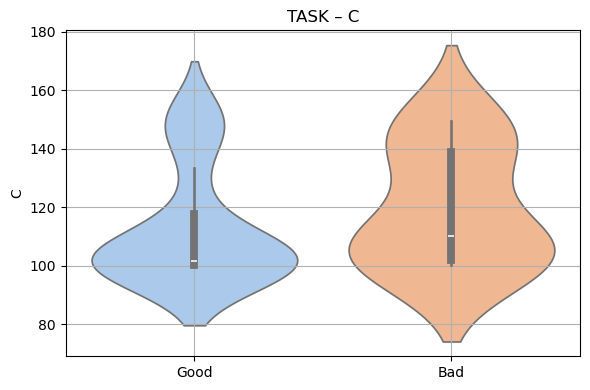

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


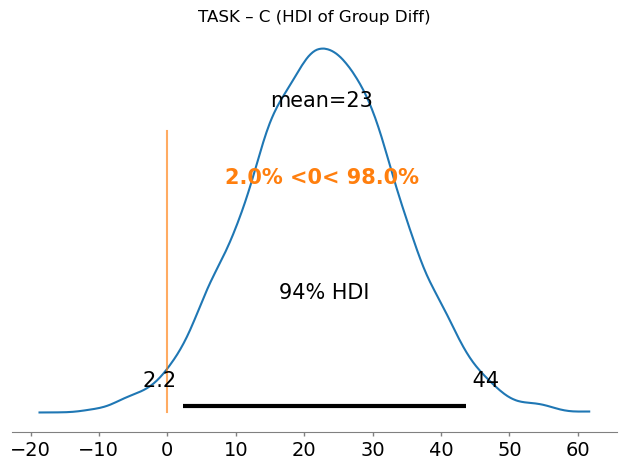

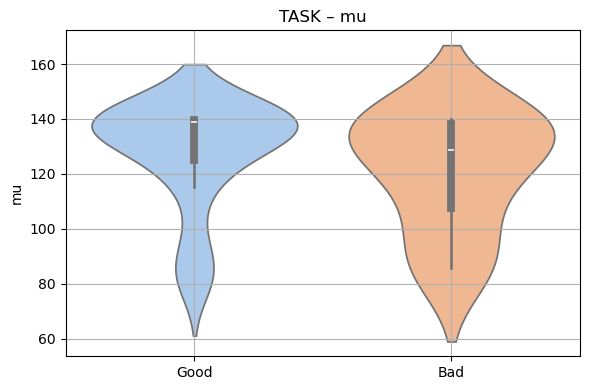

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


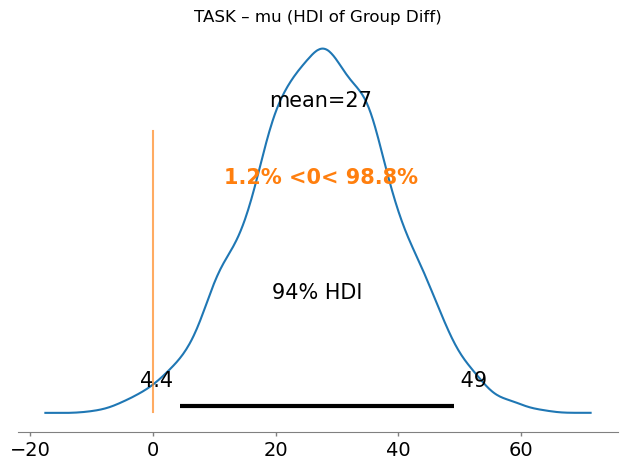

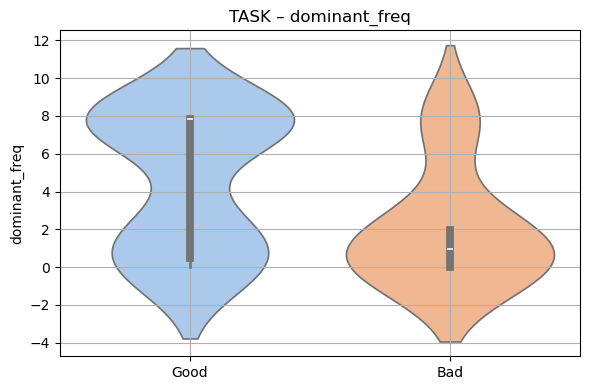

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


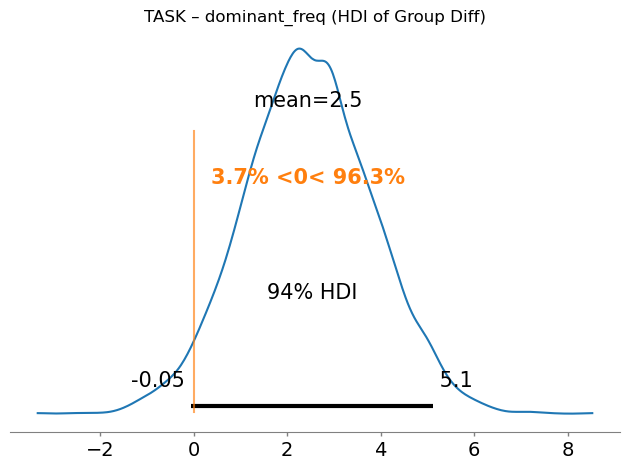

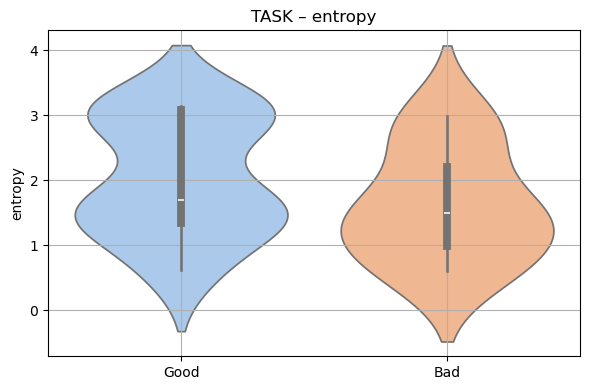

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


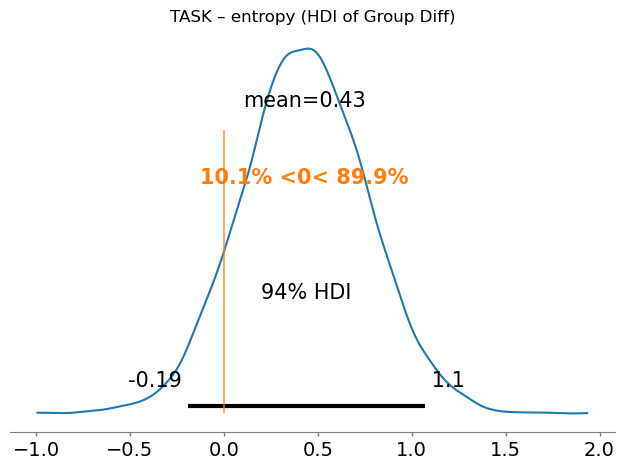

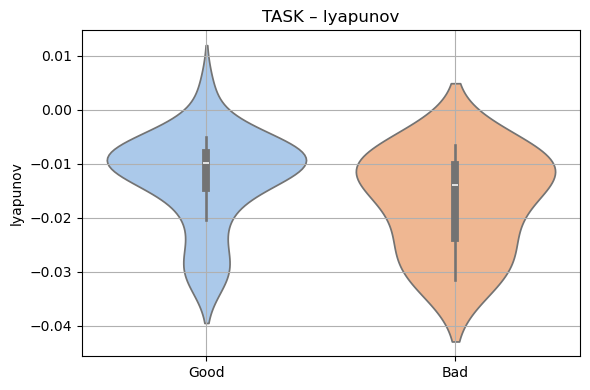

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


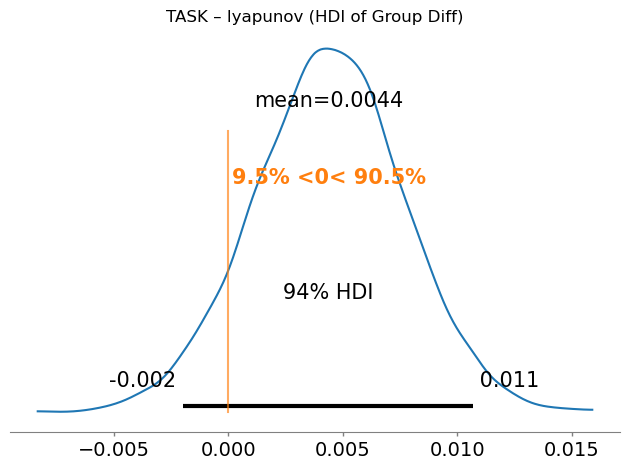

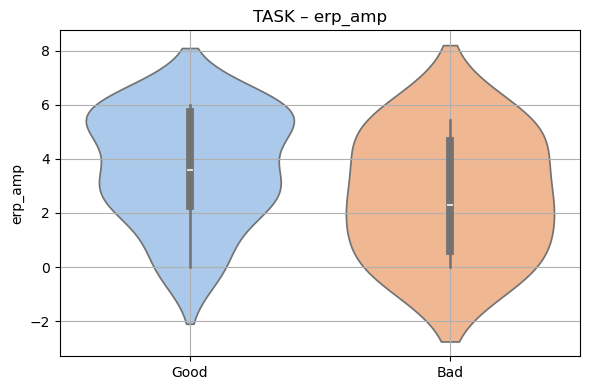

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


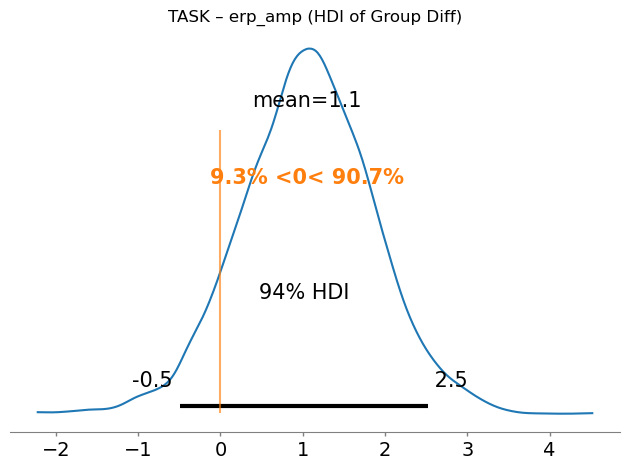

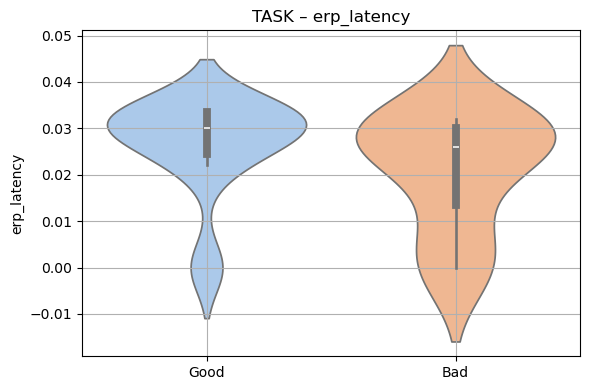

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


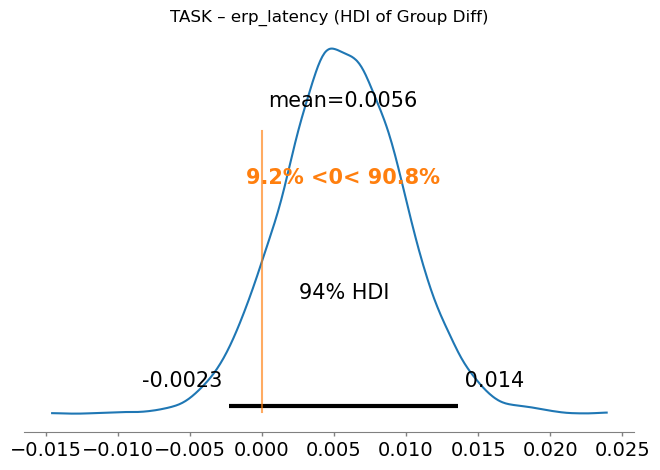

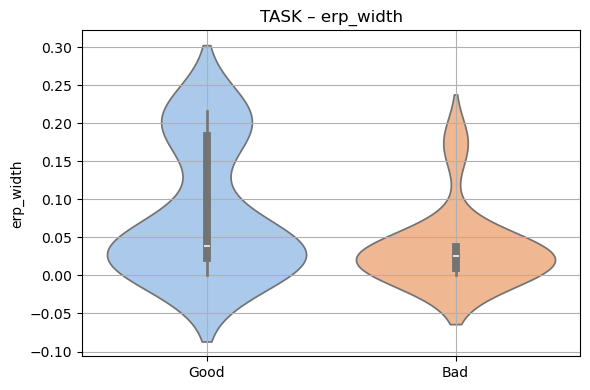

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


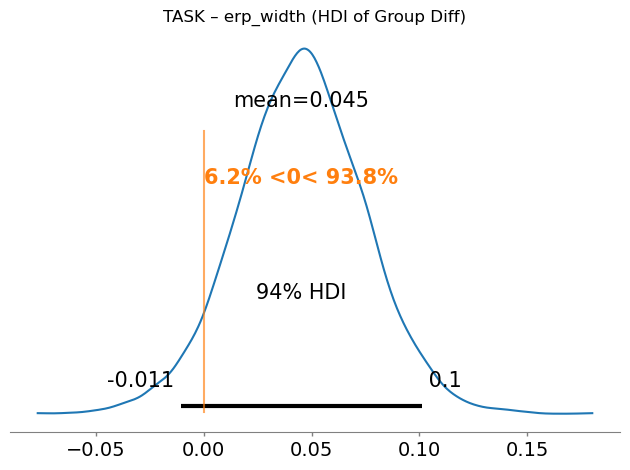

In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# === Load fitted parameters ===
with open("jansen_rit/fitted_params_rest_extended.pkl", "rb") as f:
    rest_params = pickle.load(f)

with open("jansen_rit/fitted_params_task_extended.pkl", "rb") as f:
    task_params = pickle.load(f)

# === Group definitions ===
good_ids = ['1', '2', '3', '5', '7', '8', '11', '12', '13', '15', '16', '17',
            '18', '20', '23', '24', '25', '26', '27', '28', '29', '31', '32', '33', '34', '35']

bad_ids = ['0', '4', '6', '9', '10', '14', '19', '21', '22', '30']

# === Function to extract group-wise values ===
def extract_group_data(param_dict, param_name):
    good_vals = [param_dict[sid][param_name] for sid in good_ids if sid in param_dict and param_name in param_dict[sid]]
    bad_vals = [param_dict[sid][param_name] for sid in param_dict if sid in bad_ids and param_name in param_dict[sid]]
    return good_vals, bad_vals

# === Plot function ===
def plot_violin_and_hdi(param_dict, param_list, condition="REST"):
    for param in param_list:
        good_vals, bad_vals = extract_group_data(param_dict, param)
        if len(good_vals) < 3 or len(bad_vals) < 3:
            print(f"Skipping {param} (insufficient data)")
            continue

        # Plot violin
        plt.figure(figsize=(6, 4))
        sns.violinplot(data=[good_vals, bad_vals], palette="pastel", inner="box")
        plt.xticks([0, 1], ['Good', 'Bad'])
        plt.title(f"{condition} – {param}")
        plt.ylabel(param)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot posterior difference (HDI)
        with pm.Model():
            mu_good = pm.Normal("mu_good", mu=0, sigma=10)
            mu_bad = pm.Normal("mu_bad", mu=0, sigma=10)
            sigma = pm.HalfNormal("sigma", sigma=10)

            pm.Normal("obs_good", mu=mu_good, sigma=sigma, observed=good_vals)
            pm.Normal("obs_bad", mu=mu_bad, sigma=sigma, observed=bad_vals)

            diff = pm.Deterministic("diff", mu_good - mu_bad)
            trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, progressbar=False)

        az.plot_posterior(trace, var_names=["diff"], ref_val=0)
        plt.title(f"{condition} – {param} (HDI of Group Diff)")
        plt.tight_layout()
        plt.show()

# === Parameters to plot ===
core_params = ["A", "B", "C", "mu"]
dyn_features = ["dominant_freq", "entropy", "lyapunov", "erp_amp", "erp_latency", "erp_width"]

# === Run plots ===
plot_violin_and_hdi(rest_params, core_params + dyn_features, condition="REST")
plot_violin_and_hdi(task_params, core_params + dyn_features, condition="TASK")


In [3]:
4+4

8